**"Разработка модели классификации патологий по снимкам"**

Кузьмин Олег 2024.01.03 - 2024.01.10 (05-я неделя).

  



### Техническое задание

Техническое Задание для проекта стажировки
1. Введение
Цель проекта - создание продукта с использованием искусственного интеллекта для диагностики и лечения заболеваний ВНЧС, с использованием методов машинного обучения и нейронных сетей.
2. Задачи проекта
2.1. Обработка и анализ КЛКТ и МРТ снимков
- С использованием библиотеки Pydicom, провести загрузку и обработку КЛКТ и МРТ снимков в формате DICOM.
- Применив модели машинного обучения и базу TensorFlow и Keras для выявления патологий челюстных костей на основе анализа данных снимков.
2.2. Создание системы классификации и фреймворка предсказания
- Сформировать модель классификации патологий, основанную на архитектуре сверточных нейронных сетей с использованием Keras.
- Разработать механизм определения геометрии патологий с использованием анализа изображений OpenCV.
2.3. Разработка системы представления результатов
- Создание простого веб-интерфейса с помощью FastAPI или развертывание телеграм-бота для взаимодействия пользователя с системой и получения результатов анализа КЛКТ и МРТ снимков.
2.4. Интеграция разработанной системы в рабочий процесс клиники
- Интегрировать разработанное решение в привычный рабочий процесс клиники с использованием библиотек для обслуживания модели.
3. Методы разметки
 - labelImg, Roboflow, CVAT AI, Labelbox, VGG Image Annotator (VIA), COCO Annotator, Supervise.ly,
4. Время и среда работы
- Длительность проекта: 3 месяца.
- Среда разработки: Google Colaboratory
5. Заключение
Разработанный продукт должен обеспечивать эффективную аналитику снимков для диагностики заболеваний ВНЧС и формировать дальнейший план действий для изготовления последнего элайнера, используя взаимодействие ИИ и человеческого специалиста.

Ссылка на ТЗ от клиники:
https://docs.google.com/presentation/d/17oEmE4xG3jhlg64gDHrHICy1_i2XjoUn/edit?usp=sharing&ouid=104431004874051483278&rtpof=true&sd=true

## Загрузка приложений

In [1]:
import numpy as np # Подключаем библиотеку numpy
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist                                     # pагрузка базы ч/б картинок размером 28х28 пикселей с названием Mnist/KERAS
from tensorflow.keras.datasets import mnist, fashion_mnist                      # загружаем готовые базы mnist

from tensorflow.keras import utils                                              # eтилиты для to_categorical
from sklearn.model_selection import train_test_split                            # модуль разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler                                # модуль стандартизации данных

from tensorflow.keras.models import Model, Sequential                           # подлючаем модуль создания модели НС Sequential и Modsl
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
                                                                                # подключаем модуль создания полносвязных слоев Dense
from tensorflow.keras.optimizers import Adam                                    # подключаем оптимизатор Adam

from tensorflow.keras.preprocessing import image                                # для отрисовки изображения
import pylab                                                                    # модуль построения графиков
from mpl_toolkits.mplot3d import Axes3D                                         # модуль трехмерной графики
import matplotlib.pyplot as plt                                                 # отрисовка изображений
from PIL import Image                                                           # отрисовка изображений
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
                                                                                # отрисовывать изображения в ноутбуке, а не в консоль или файk

import os
from google.colab import files                                                  # для загрузки своей картинки
from tensorflow.keras import backend as K                                       # подтягиваем базовые керасовские функции
from tensorflow.keras.callbacks import LambdaCallback
from google.colab import drive                                                  # модуль для работы с google диском
import time, random
import zipfile                      # Для начала нам нужно импортировать модуль zipfile:


## Определимся с терминами и понятиями в имеющейся у Заказчика базе знаний

In [2]:
# В список собраны сокращенные названия диагнозов после анализа снимков с размерами
PR_list = ['PR1_norm', 'PR1_later', 'PR1_medial',
           'PR2_norm', 'PR2_kompres','PR2_distrak', 'PR2_dictal', 'PR2_mezial',
           'PR3_norm', 'PR3_kompres', 'PR3_distrak', 'PR3_later', 'PR3_medial']
print('Колонка сокращенных диагнозов после анализа снимков. Разместить в карте пациента')
PR_list

Колонка сокращенных диагнозов после анализа снимков. Разместить в карте пациента


['PR1_norm',
 'PR1_later',
 'PR1_medial',
 'PR2_norm',
 'PR2_kompres',
 'PR2_distrak',
 'PR2_dictal',
 'PR2_mezial',
 'PR3_norm',
 'PR3_kompres',
 'PR3_distrak',
 'PR3_later',
 'PR3_medial']

In [3]:
# словарь сокращенных и полных названий диагнозов. Для трех разных проекций
PR_dist = {'PR1_norm':'Центральное положение суставной головки Нормально',
          'PR1_later':'Латеральное положение суставной головки ',
          'PR1_medial':'Медиальное положение суставной головки',

          'PR2_norm':'Центральное положение суставной головки Нормально',
          'PR2_kompres':'Компрессия. Сужение суставной щели',
          'PR2_distrak':'Дистракция. Расширение суставной щели',
          'PR2_dictal':'Дистальное положение суставной головки',
          'PR2_mezial': 'Мезиальное положение суставной головки',

          'PR3_norm':'Центральное положение суставной головки Нормально',
          'PR3_kompres': 'Компрессия. Сужение суставной щели',
          'PR3_distrak':'Дистракция. Расширение суставной щели ',
          'PR3_later':'Лотеральное положение суставной головки',
          'PR3_medial':'Медиальное положение суставной головки'}
print('Список ключей словаря', '\n', PR_dist.keys())

Список ключей словаря 
 dict_keys(['PR1_norm', 'PR1_later', 'PR1_medial', 'PR2_norm', 'PR2_kompres', 'PR2_distrak', 'PR2_dictal', 'PR2_mezial', 'PR3_norm', 'PR3_kompres', 'PR3_distrak', 'PR3_later', 'PR3_medial'])


In [4]:
# Список обозначений мест измерений на снимках
LaPa = ['pr_diag','l<', 'l>', 'l^', 'lv', 'p<', 'p>', 'p^', 'pv']
LaPa

['pr_diag', 'l<', 'l>', 'l^', 'lv', 'p<', 'p>', 'p^', 'pv']

In [5]:
#  Список проекций в которых производится съемка
Proekc = ['PR1 Аксиальная проекция','PR2 Сагитальная проекция','PR3 Корональная проекция']
print('Горизонтальная проекция      ', Proekc[0])
print('Вертикальная проекция, слева ', Proekc[1])
print('Вертикальная проекция, справа', Proekc[2])

Горизонтальная проекция       PR1 Аксиальная проекция
Вертикальная проекция, слева  PR2 Сагитальная проекция
Вертикальная проекция, справа PR3 Корональная проекция


In [6]:
interval = [9,17,25,33,41,49,57,65,73,81,89,97,105]

Создадим пустую форму карты пациента для записи в нее из общего DS информации


In [7]:
column = ['pr_diag','PR1_norm_La<',  'PR1_norm_La>', 'PR1_norm_La^', 'PR1_norm_Lav', 'PR1_norm_Pa<', 'PR1_norm_Pa>', 'PR1_norm_Pa^', 'PR1_norm_Pav']
df_karta0 =pd.DataFrame(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13], columns= LaPa) #column)
df_karta0.shape
df_karta0

pr_diag   l<   l>   l^   lv   p<   p>   p^   pv
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
5      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
6      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
7      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
8      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
9      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
10     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
11     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
12     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
13     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

## Локальные функции

Функция занесения индивидуальных данных из DF в учетную карточку с результатами исследований

In [8]:
# Код формирование карты пациента из открытого на предыдущем этапе df_com
# полученные данные в виде строки в более удобочитаемую карточку

def gen_karta (str_pacienta, ID ):  #(df_karta0, interval, PR_list, str_pacienta ):
  a = 1
  b = 0
  PR = 0
  karta_P = df_karta0.copy()

  for ca in PR_list:      # PR1_norm  цикл движения по столбцу сокращенных диагнозов в карке пациента

    karta_P.iloc[PR,0] = ca
    B = interval[b]
    #print('B',B)
    s = str_pacienta.iloc[0,a:B]
    ss = list(s)
    #print(ss)
    karta_P.iloc[PR,1:9] = ss
    a = B
    b += 1
    PR += 1
  karta_P.iloc[13,0] = 'ID пациента'
  karta_P.iloc[13,1] = ID
    #print(ca, 'обработан')
  return karta_P

Функция преобразования изображения в np-массив

In [9]:
def load_images(norm_list, img_height, img_width):
  ''' Функция преобразования изображения в np-массив
      Вход: передаем список распакованых в папку /content/drive/MyDrive/.... файлов из zip архива
      высоту и ширину картинки к которой будут преобразованы загружаемые изображения
  '''
  list_images = []                                                             # создаем пустой список в который будем загружать изображения
  for img in norm_list:                                                        # цикл по списку распакованных файлов
    pch = os.path.join(images_dir, img)                                        # соберем полный путь к очередному файлу (состоит из пути к папке + имя файла)

    wq = image.load_img(pch, target_size=(img_height, img_width), color_mode='grayscale') # Загружаем изображение с помощью image.load_img(), конвертируя его в нужный формат
                                                                                          # подаем на вход: 1. путь к файлу 2. размер получаемой картинки. 3.цветовую гамму
    list_images.append(image.img_to_array(wq)/255)                             # переводим изображение в np-массив, нормируем в диапазон от 0 до 1 и добавляем в список
    norm_np =  np.array(list_images)                                           # переводим список изображений в numpy массив

  return norm_np                                                               # возвращаем numpy массив загруженных избражений

Функция для параллельного вывода правой и левой головки в одной проекции

надо разделить папку проекции на Ла и Па  

In [10]:
def plotImages(xTrain, pred, shape=(112, 80)): # создадим функцию для вывода изображений как картинок
  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(14, 7)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

### Центральное положение суставной головки. Норма

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR3_norm.zip'             # путь к архиву
norm = zipfile.ZipFile(zip_file, 'r')                           # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
norm.extractall('/content/drive/MyDrive/BD/PR3_norm/')          # достаем все файлы из архива и пишем в папку PR3_norm
norm_list = os.listdir('/content/drive/MyDrive/BD/PR3_norm')    # составим список всех файлов в папке PR3_norm
print('Кол-во файлов в папке /BD/PR3_norm/', len(norm_list))
#norm_list


Кол-во файлов в папке /BD/PR3_norm/ 161


In [ ]:
norm_list[67:80]

['è99Å¬.jpg',
 'è100ï¬.jpg',
 'è102ï¬.jpg',
 'è102Å¬.jpg',
 'è103ï¬.jpg',
 'è103Å¬.jpg',
 'è104Å¬.jpg',
 'è106ï¬.jpg',
 'è107ï¬.jpg',
 'è107Å¬.jpg',
 'è109ï¬.jpg',
 'è110ï¬.jpg',
 'è111ï¬.jpg']

### Компрессия. Сужение суставной щели

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR3_kompres.zip'                # путь к архиву
kompres = zipfile.ZipFile(zip_file, 'r')                              # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
kompres.extractall('/content/drive/MyDrive/BD/PR3_kompres/')          # достаем все файлы из архива и пишем в папку PR3_kompres
kompres_list = os.listdir('/content/drive/MyDrive/BD/PR3_kompres')    # составим список всех файлов в папке PR3_kompres
print('Кол-во файлов в папке', len(kompres_list))
#kompres_list


Кол-во файлов в папке 132


In [ ]:
kompres_list[44:52]

['è95Å¬.jpg',
 'è100Å¬.jpg',
 'è104ï¬.jpg',
 'è108ï¬.jpg',
 'è108Å¬.jpg',
 'è109Å¬.jpg',
 'è110Å¬.jpg',
 'è114Å¬.jpg']

### Дистракция. Расширение суставной щели

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR3_distrak.zip'             # путь к архиву
distrak = zipfile.ZipFile(zip_file, 'r')                           # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
distrak.extractall('/content/drive/MyDrive/BD/PR3_distrak/')          # достаем все файлы из архива и пишем в папку PR3_distrak
distrak_list = os.listdir('/content/drive/MyDrive/BD/PR3_distrak')    # составим список всех файлов в папке PR3_distrak
print('Кол-во файлов в папке', len(distrak_list))
#distrak_list


Кол-во файлов в папке 46


In [ ]:
print('Нет пациентов с номерами от 100 до 110')

Нет пациентов с номерами от 100 до 110


### Латеральное положение суставной головки.

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR3_later.zip'                # путь к архиву
later = zipfile.ZipFile(zip_file, 'r')                              # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
later.extractall('/content/drive/MyDrive/BD/PR3_later/')          # достаем все файлы из архива и пишем в папку PR3_later
later_list = os.listdir('/content/drive/MyDrive/BD/PR3_later')    # составим список всех файлов в папке PR3_later
print('Кол-во файлов в папке', len(later_list))
#later_list


Кол-во файлов в папке 205


In [ ]:
later_list[102:107]

['è97Å¬.jpg', 'è101ï¬.jpg', 'è105ï¬.jpg', 'è105Å¬.jpg', 'è115ï¬.jpg']

### Мезиальное положение суставной головки.

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR3_medial.zip'                # путь к архиву
medial = zipfile.ZipFile(zip_file, 'r')                              # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
medial.extractall('/content/drive/MyDrive/BD/PR3_medial/')          # достаем все файлы из архива и пишем в папку PR3_medial
medial_list = os.listdir('/content/drive/MyDrive/BD/PR3_medial')    # составим список всех файлов в папке PR3_medial
print('Кол-во файлов в папке', len(medial_list))
#medial_list


Кол-во файлов в папке 25


In [ ]:
medial_list[4:7]

['è60Å¬.jpg', 'è106Å¬.jpg', 'è117Å¬.jpg']

Код из словаря операторов

In [ ]:
#zip_file = '/content/drive/MyDrive/Colab Notebooks/ДЗ 16 Автокодировщики /facez.zip'    # путь к архиву
#norm = zipfile.ZipFile(zip_file, 'r')                                         # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
#norm.extractall('/content/drive/MyDrive/BD/--------/')                        # достаем все файлы из архива и пишем в папку Facez

images_dir = '/content/drive/MyDrive/BD/PR1_norm'                              # зададим имя папки в которую распоковали изображения
norm_list = os.listdir('/content/drive/MyDrive/BD/PR1_norm')                   # составим список всех файлов в папке PR1_norm
print('Кол-во файлов в папке', len(norm_list))

#norm_list

Кол-во файлов в папке 224


In [ ]:
print('Смотрим название файла из списка', norm_list[211])
print('Переводим файл из jpg формата в np массив')
pch = os.path.join(images_dir, norm_list[211])                                 # соберем полный путь к очередному файлу
wq = image.load_img('/content/drive/MyDrive/BD/PR1_norm/è240Åá.jpg')           # загружаем изображение с помощью image.load_img()
wq_np = image.img_to_array(wq)                                                 # переводим изображение в numpy массив
print('Тип переменной', type(wq_np))
print('Размер np-изображения',wq_np.shape)

Смотрим название файла из списка è240Åá.jpg
Переводим файл из jpg формата в np массив
Тип переменной <class 'numpy.ndarray'>
Размер np-изображения (603, 976, 3)


Переведем все файлы из списка в np массив с помощью функции load_images

In [ ]:
cur_time = time.time()
xTrain_imag = load_images(norm_list, img_height, img_width)                    # загрузим избражения из списка с задаными размерами картинки
print ('Время загрузки: ', round(time.time()-cur_time, 2), 'с', sep='')
print('Размерность массива', xTrain_imag.shape)                                # выведем размерность массива

Время загрузки: 28.71с
Размерность массива (224, 603, 976, 1)


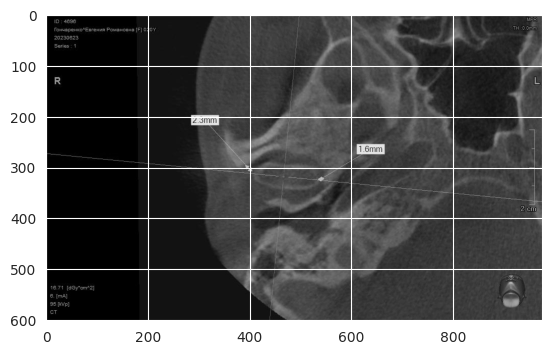

In [ ]:
plt.imshow(xTrain_imag[np.random.randint(0, xTrain_imag.shape[0])].reshape(img_height,img_width), cmap='gray') # выведем случайное изображение
plt.show()

### Смотрим на формы головки

In [ ]:
images_dir = '/content/drive/MyDrive/BD/PR1_norm'                              # путь к папке с изображениями
img_height = 603   # 112                                                       # зададим высоту изображений
img_width = 976    # 80                                                        # зададим ширину изображений

# Предварительно отобрали снимки с различными формами
norm_list2 = ['è101ïá.jpg', 'è110ïá.jpg']                                      # овальная форма
norm_list3 = ['è108ïá.jpg',  'è144ïá.jpg', 'è187Åá.jpg']                       # другие, не овальные формы

In [ ]:
xTrain_imag2 = load_images(norm_list2, img_height, img_width)                  # загрузим избражений овальной формы с разным числом измерений
xTrain_imag3 = load_images(norm_list3, img_height, img_width)                  # загрузим избражений разной формы с разным числом измерений
print('Размерность массива изображений овальной формы', xTrain_imag2.shape)    # выведем размерность массива
print('Размерность массива изображений разной формы  ', xTrain_imag3.shape)    # выведем размерность массива

Размерность массива изображений овальной формы (2, 603, 976, 1)
Размерность массива изображений разной формы   (3, 603, 976, 1)


Смотрим снимки с овальной формой

 è101ïá.jpg
                                                                                                   è110ïá.jpg


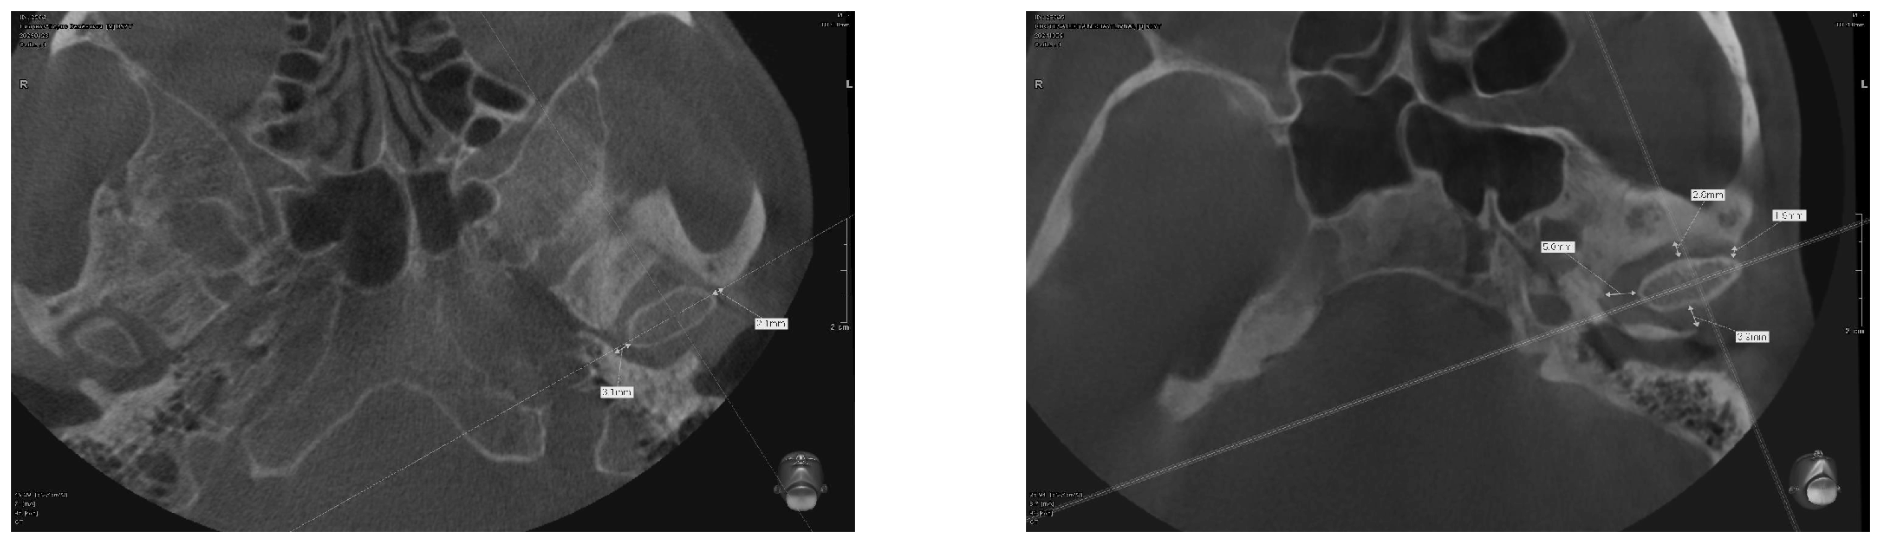

In [ ]:
plt.figure(figsize=(24,24)) # указываем размеры фигуры
n = 2

for i in range(n): # для каждой картинки из n(5)
   print(' '*(i*98), norm_list2[i])
   for g in range(len(xTrain_imag2)):
    ax = plt.subplot(1, n, g+1) #i + 1) # выведем область рисования Axes
    plt.imshow(xTrain_imag2[g]) #.reshape(603,976)) # отрисуем правильные картинки в размере 112*80
    plt.gray() # выведем в черно-белом цвете
    ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
    ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

plt.show()


Смотрим снимки с не овальной формой

 è108ïá.jpg
                                                                  è144ïá.jpg
                                                                                                                                   è187Åá.jpg


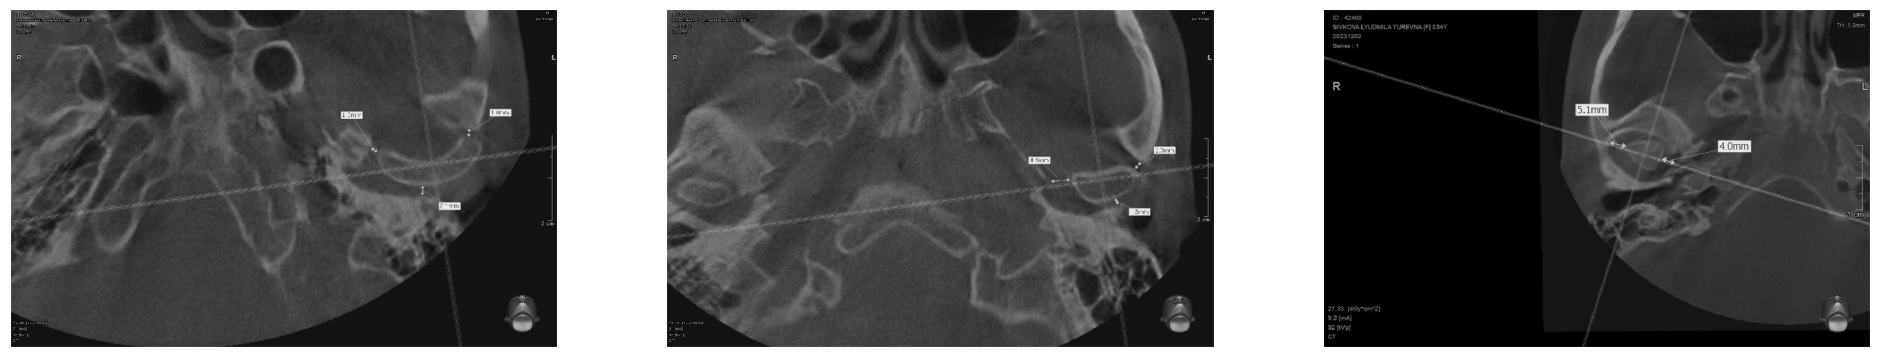

In [ ]:
plt.figure(figsize=(24,24)) # указываем размеры фигуры
n = 3

for i in range(n): # для каждой картинки из n(5)
   print(' '*(i*65), norm_list3[i])
   for g in range(len(xTrain_imag3)):
    ax = plt.subplot(1, n, g+1) #i + 1) # выведем область рисования Axes
    plt.imshow(xTrain_imag3[g]) #.reshape(603,976)) # отрисуем правильные картинки в размере 112*80
    plt.gray() # выведем в черно-белом цвете
    ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
    ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

plt.show()

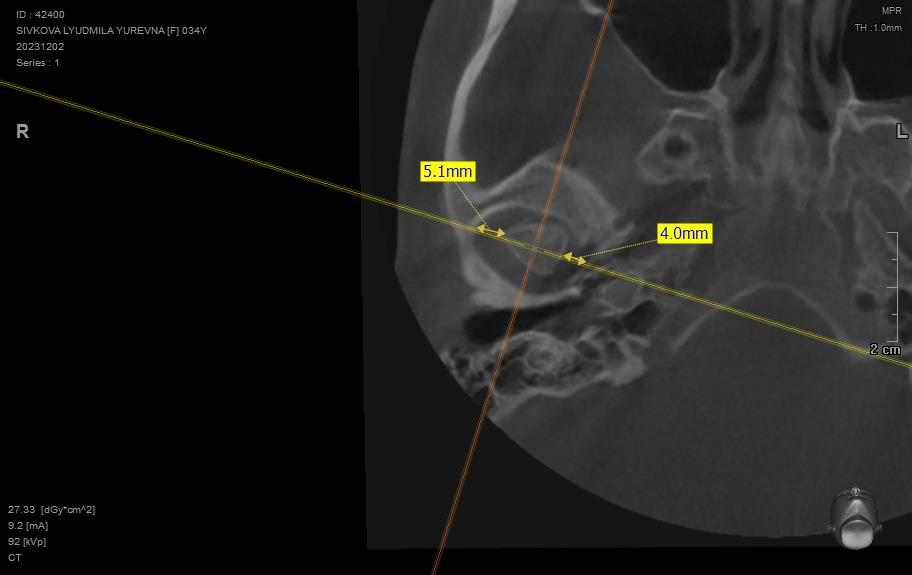

In [ ]:
# Путь к файлу изображения
test_path = '/content/drive/MyDrive/BD/PR1_norm/è187Åá.jpg'
img = Image.open(test_path)

# Вывод изображения на экран
display(img)

# Работа с табличными данными


# Загрузка DF

In [11]:
# Укажим путь к файлу с данными на моем диске
way = '/content/drive/MyDrive/Стажировка 3/df_iris_sagital215_D10.xlsx'
df_irsa = pd.read_excel(way)  # Чтение данных из файла excel в pandas.DataFrame
print(df_irsa.shape)
li = df_irsa.columns.tolist()
print('len(li)', len(li))
df_irsa[150:160]

(215, 22)
len(li) 22


ID  PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^   Σ/2    Δ<  \
150  Nw176           1.7           2.1           2.3   0.826087  1.90  0.20   
151  Nw177           1.2           2.7           2.8   0.696429  1.95  0.75   
152  Nw178           1.8           1.3           2.1   0.738095  1.55 -0.25   
153  Nw179           2.9           3.5           4.0   0.800000  3.20  0.30   
154  Nw180           3.4           2.5           2.4   1.229167  2.95 -0.45   
155  Nw181           2.6           1.9           4.2   0.535714  2.25 -0.35   
156  Nw182           1.5           1.2           1.5   0.900000  1.35 -0.15   
157  Nw183           1.8           3.6           2.5   1.080000  2.70  0.90   
158  Nw184           3.3           2.6           3.9   0.756410  2.95 -0.35   
159  Nw185           1.3           4.5           3.6   0.805556  2.90  1.60   

            %   Lc < /  Lc ^    Lc > /  Lc ^   ...     d10      d4     d5  \
150  0.117647        0.739130        0.913043  ...  distal     NaN    NaN   
151  0.625000        0.428571        0.964286  ...     NaN     NaN   komp   
152 -0.138889        0.857143        0.619048  ...  distal     NaN    NaN   
153  0.103448        0.725000        0.875000  ...     NaN    norm    NaN   
154 -0.132353        1.416667        1.041667  ...  distal     NaN    NaN   
155 -0.134615        0.619048        0.452381  ...     NaN     NaN  distr   
156 -0.100000        1.000000        0.800000  ...  distal     NaN    NaN   
157  0.500000        0.720000        1.440000  ...  mezial  mezial    NaN   
158 -0.106061        0.846154        0.666667  ...  distal     NaN    NaN   
159  1.230769        0.361111        1.250000  ...  mezial  mezial    NaN   

         d6      d7      d9      d8      d3     d2    d1  
150  distal     NaN     NaN  distal  distal    NaN   NaN  
151    komp    komp     NaN     NaN     NaN    NaN  komp  
152  distal     NaN     NaN  distal  distal    NaN   NaN  
153     NaN     NaN     NaN     NaN    norm   norm  norm  
154  distal     NaN     NaN  distal  distal    NaN   NaN  
155     NaN     NaN   distr   distr     NaN  distr   NaN  
156  distal     NaN     NaN  distal  distal    NaN   NaN  
157     NaN  mezial  mezial     NaN     NaN    NaN   NaN  
158  distal     NaN     NaN  distal  distal    NaN   NaN  
159     NaN  mezial  mezial     NaN     NaN    NaN   NaN  

[10 rows x 22 columns]

## Статистики


Заменяем все пропуски словом -1

In [ ]:
#df_coms1 = df_coms.fillna("-1").copy()  # С помощью метода .fillna() заменяем все пропуски словом -1

In [ ]:
df_irsa.columns
#e = df_irsa.columns
#e

Index(['ID', 'PR2_norm_Lc<', 'PR2_norm_Lc>', 'PR2_norm_Lc^', 'Σ/2 / Lc^',
       'Σ/2', 'Δ<', '%', ' Lc < /  Lc ^ ', ' Lc > /  Lc ^ ', 'Σ(3)',
       'diagnosis'],
      dtype='object')

In [ ]:
df_irsa.count() # Метод count считает сколько всего непустых записей в каждом столбце

ID                230
PR2_norm_Lc<      230
PR2_norm_Lc>      230
PR2_norm_Lc^      230
Σ/2 / Lc^         230
Σ/2               230
Δ<                230
%                 230
 Lc < /  Lc ^     230
 Lc > /  Lc ^     230
Σ(3)              230
diagnosis         230
dtype: int64

In [ ]:
df_irsa.info() # Метод count считает сколько всего непустых записей в каждом столбце

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              230 non-null    object 
 1   PR2_norm_Lc<    230 non-null    float64
 2   PR2_norm_Lc>    230 non-null    float64
 3   PR2_norm_Lc^    230 non-null    float64
 4   Σ/2 / Lc^       230 non-null    float64
 5   Σ/2             230 non-null    float64
 6   Δ<              230 non-null    float64
 7   %               230 non-null    float64
 8    Lc < /  Lc ^   230 non-null    float64
 9    Lc > /  Lc ^   230 non-null    float64
 10  Σ(3)            230 non-null    float64
 11  diagnosis       230 non-null    object 
dtypes: float64(10), object(2)
memory usage: 21.7+ KB


In [17]:
df_irsa.nunique()

ID                215
PR2_norm_Lc<       50
PR2_norm_Lc>       62
PR2_norm_Lc^       63
Σ/2 / Lc^         189
Σ/2                82
Δ<                103
%                 181
 Lc < /  Lc ^     181
 Lc > /  Lc ^     164
Σ(3)              113
diagnosis           5
d10                 2
d4                  2
d5                  2
d6                  2
d7                  2
d9                  2
d8                  2
d3                  2
d2                  2
d1                  2
dtype: int64

In [ ]:
df_irsa.describe() # информация не интересна

PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^   Σ/2 / Lc^         Σ/2  \
count    230.000000    230.000000    230.000000  230.000000  230.000000   
mean       2.063000      2.230435      2.912652    0.805249    2.146717   
std        0.701547      1.103347      1.151117    0.283312    0.629127   
min        0.500000      0.400000      0.800000    0.358974    0.750000   
25%        1.500000      1.500000      2.200000    0.604206    1.700000   
50%        2.000000      1.935000      2.755000    0.761754    2.100000   
75%        2.500000      2.600000      3.660000    0.920789    2.500000   
max        3.900000      7.400000      7.600000    2.416667    4.700000   

               Δ<           %   Lc < /  Lc ^    Lc > /  Lc ^         Σ(3)  
count  230.000000  230.000000      230.000000      230.000000  230.000000  
mean     0.083717    0.132717        0.805281        0.805217    7.206087  
std      0.677474    0.501519        0.380145        0.331826    2.188159  
min     -1.150000   -0.416667        0.140625        0.102564    2.500000  
25%     -0.350000   -0.139856        0.522554        0.593750    5.825000  
50%      0.000000    0.000000        0.741338        0.750000    6.900000  
75%      0.350000    0.213346        1.000000        0.959603    8.300000  
max      2.800000    3.600000        2.166667        2.666667   16.800000

<ipython-input-42-bdd587377a28>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask_1 = np.tril(df_irsa.corr())
<ipython-input-42-bdd587377a28>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_irsa.corr(), cmap='coolwarm', center= 0, square=True, annot=True, linewidths =0.05, linecolor= 'gray', mask = mask_1)


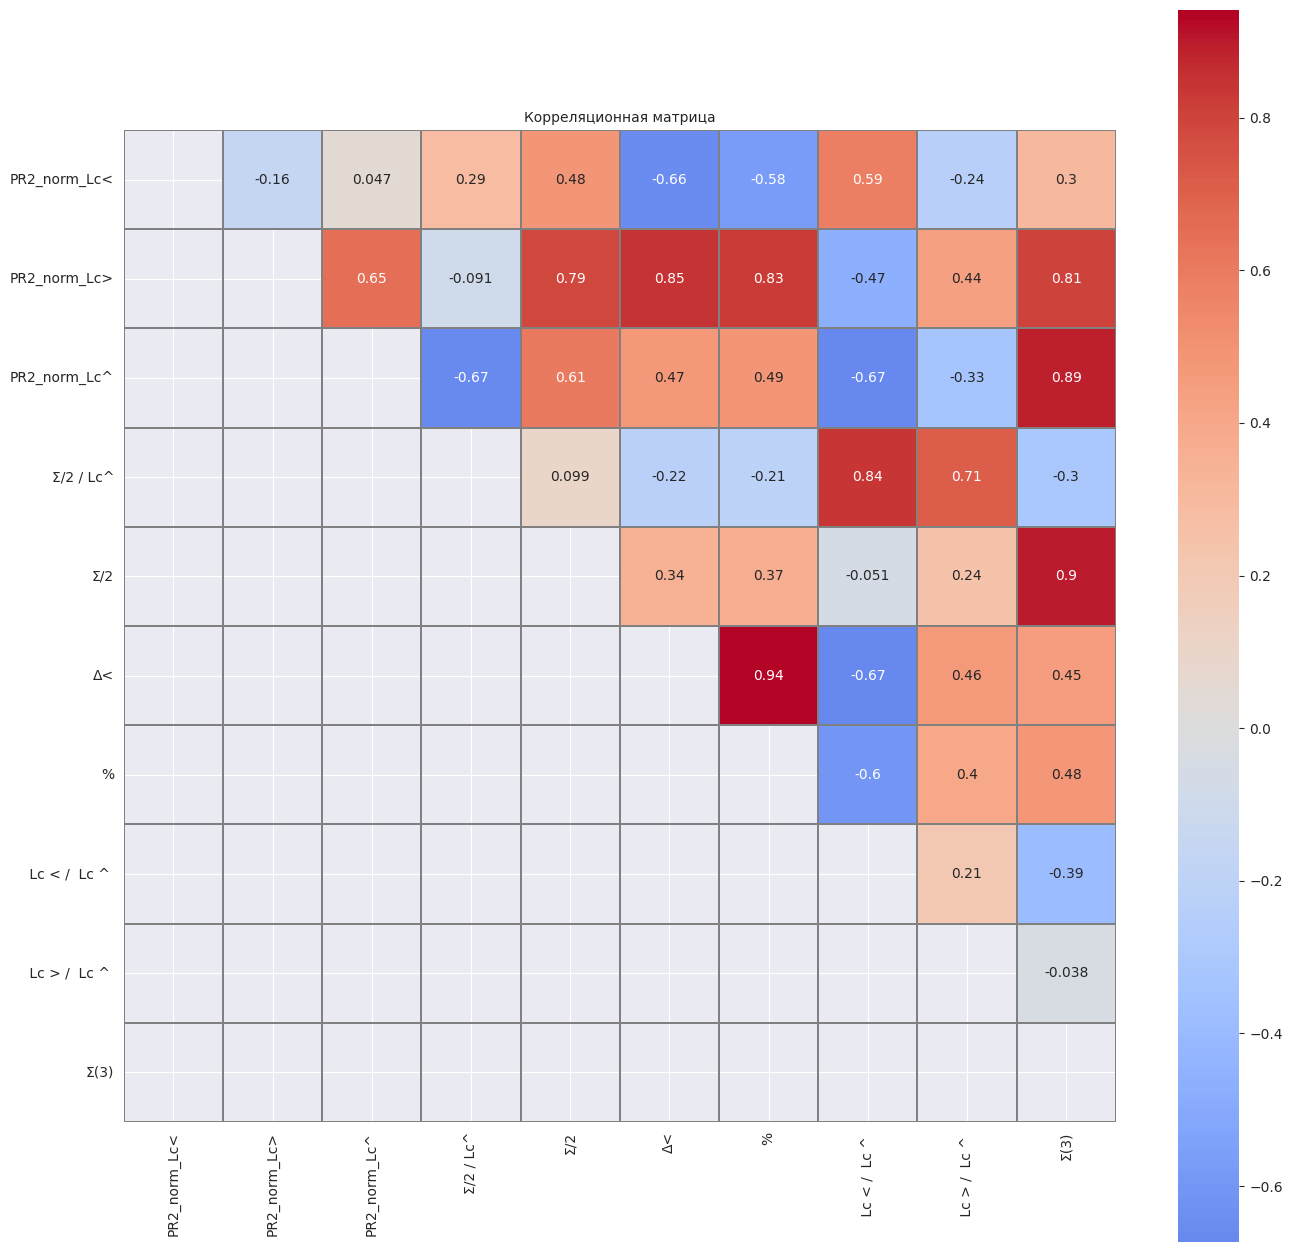

In [ ]:
# Таблица корреляции признаков
mask_1 = np.tril(df_irsa.corr())
plt.figure(figsize=(16,16))
sns.heatmap(df_irsa.corr(), cmap='coolwarm', center= 0, square=True, annot=True, linewidths =0.05, linecolor= 'gray', mask = mask_1)
plt.title("Корреляционная матрица", fontsize=10)
plt.show()

Соберем все не пустые данные в столбце в один список

## Графический анализ


### Относитольно первого столбца

['PR2_norm_Lc<', 'PR2_norm_Lc>', 'PR2_norm_Lc^', 'Σ/2 / Lc^', 'Σ/2', 'Δ<', '%', ' Lc < /  Lc ^ ', ' Lc > /  Lc ^ ', 'Σ(3)', 'diagnosis']


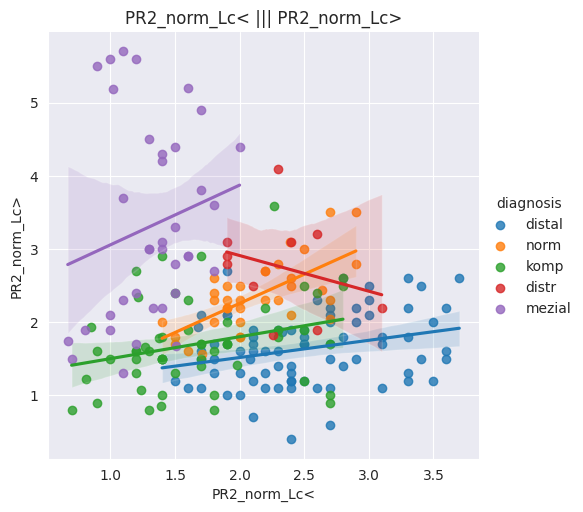

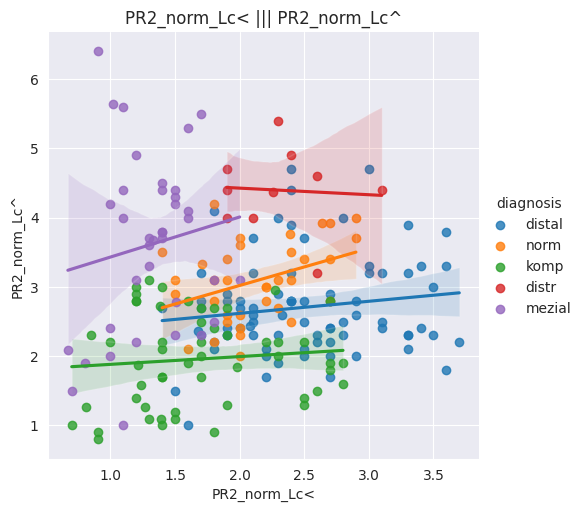

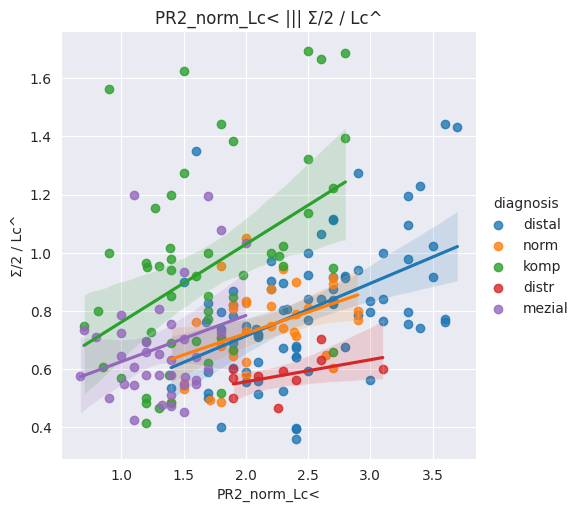

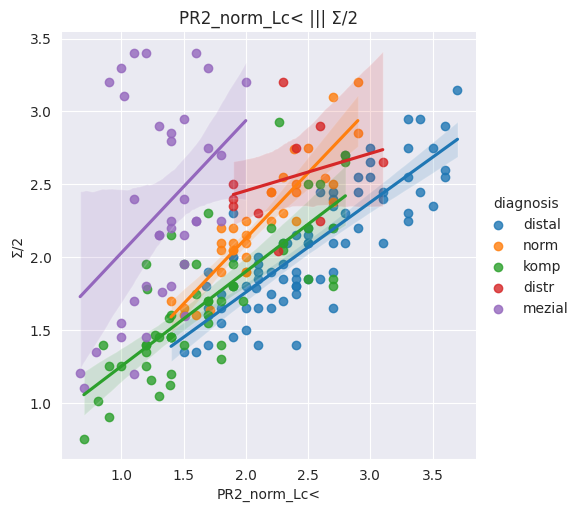

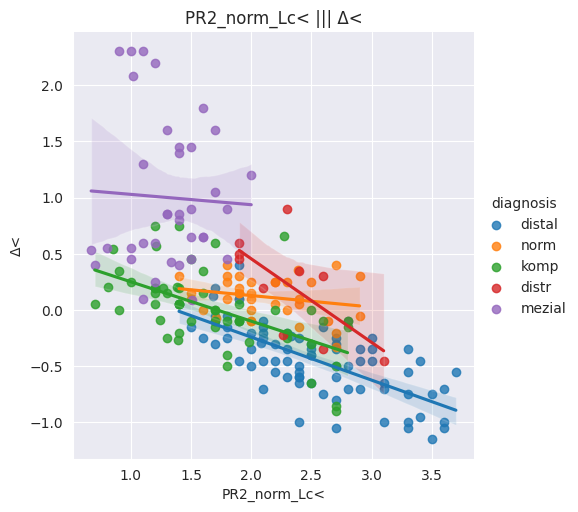

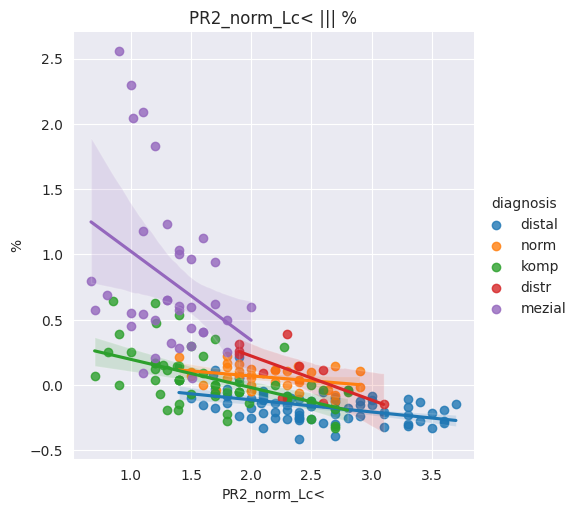

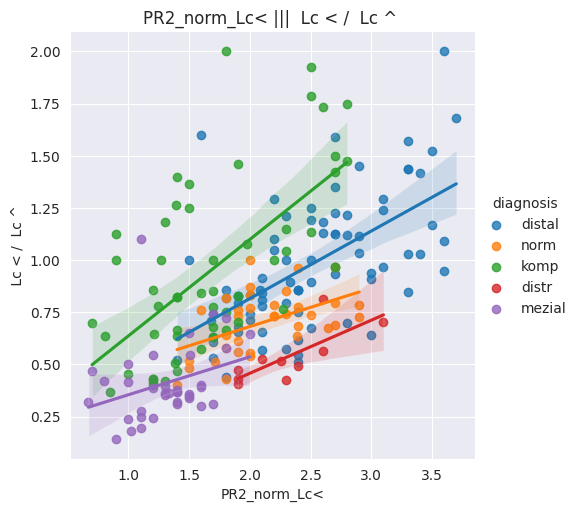

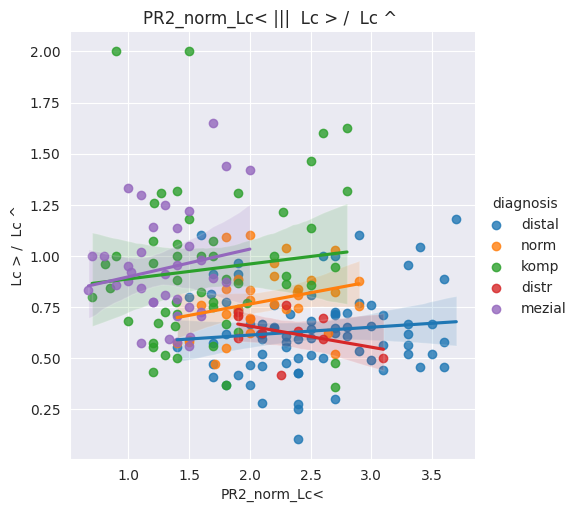

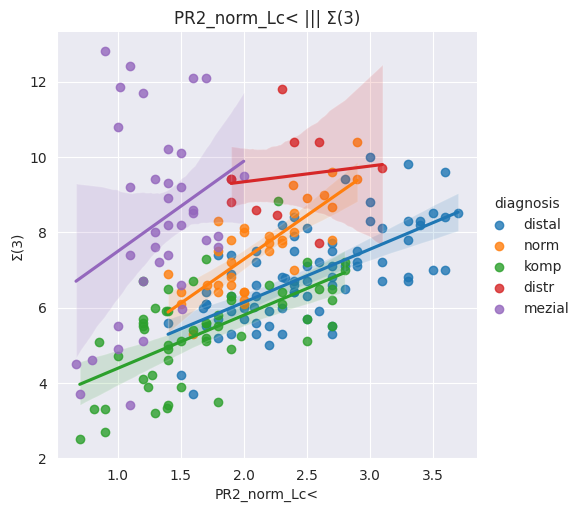

In [ ]:
sns.set_style('darkgrid')   # style = ['darkgrid', 'whitegrid', 'dark', 'white']
sir = 1                     # анализируем все столбцы относительно sir
sir_an = li[sir:]
print(sir_an)
for e in range((len(sir_an)-2)):
  el = e +2
  sns.lmplot(data=df_irsa, x=df_irsa.columns[sir], y=df_irsa.columns[el], hue='diagnosis') # df.columns[0] - это значения столбика sepal length
                                                                                           # df.columns[1] - это значения столбика sepal width
  title = str(li[sir]+' ||| '+ li[el] )
  plt.title(title)
  plt.show()

In [ ]:
#задаем маску
mask = df_irsa['diagnosis'] == 'norm'
mask.head() # Отобразим маску

norm = df_irsa[mask] # Выбираем данные из датафрейма в соответствии с маской и записываем их в новый даатафрейм temp
print(norm.shape)
norm.head(5) # Отображаем temp

(35, 12)


ID  PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^   Σ/2    Δ<  \
3   Nw8           2.7           3.5           3.4   0.911765  3.10  0.40   
4   Nw9           2.2           2.3           3.0   0.750000  2.25  0.05   
5  Nw10           2.2           2.7           3.0   0.816667  2.45  0.25   
8  Nw13           2.2           2.7           2.8   0.875000  2.45  0.25   
9  Nw14           2.4           2.6           3.5   0.714286  2.50  0.10   

          %   Lc < /  Lc ^    Lc > /  Lc ^   Σ(3) diagnosis  
3  0.148148        0.794118        1.029412   9.6      norm  
4  0.022727        0.733333        0.766667   7.5      norm  
5  0.113636        0.733333        0.900000   7.9      norm  
8  0.113636        0.785714        0.964286   7.7      norm  
9  0.041667        0.685714        0.742857   8.5      norm

### Относитольно второго "PR2_norm_Lc>" столбца

['PR2_norm_Lc>', 'PR2_norm_Lc^', 'Σ/2 / Lc^', 'Σ/2', 'Δ<', '%', ' Lc < /  Lc ^ ', ' Lc > /  Lc ^ ', 'Σ(3)', 'diagnosis']


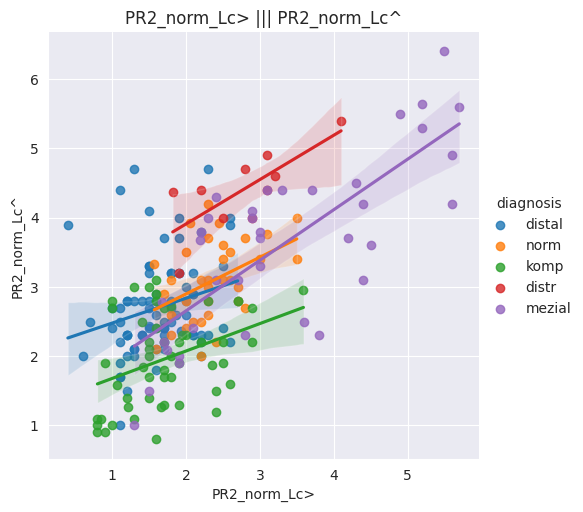

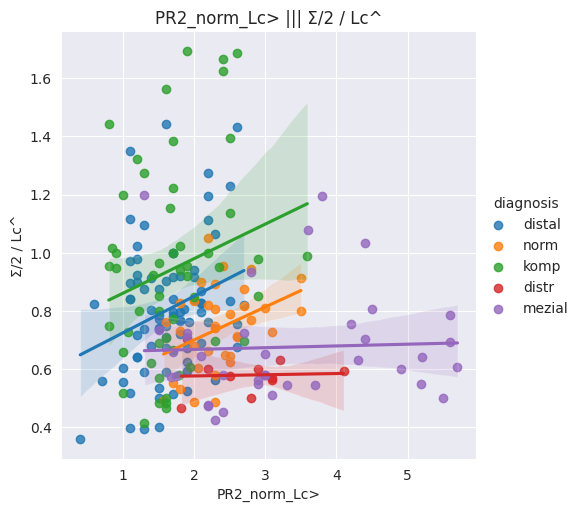

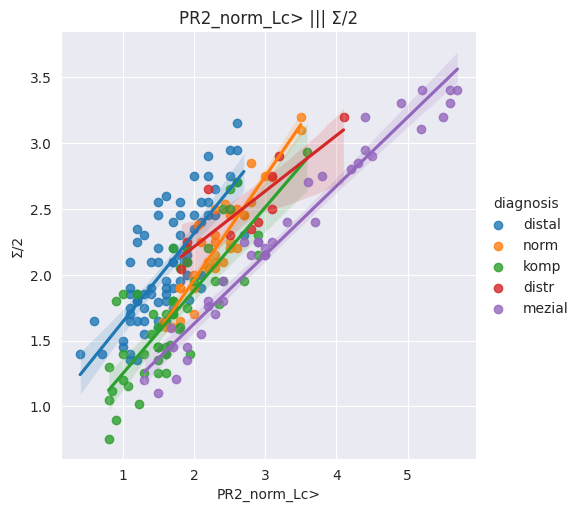

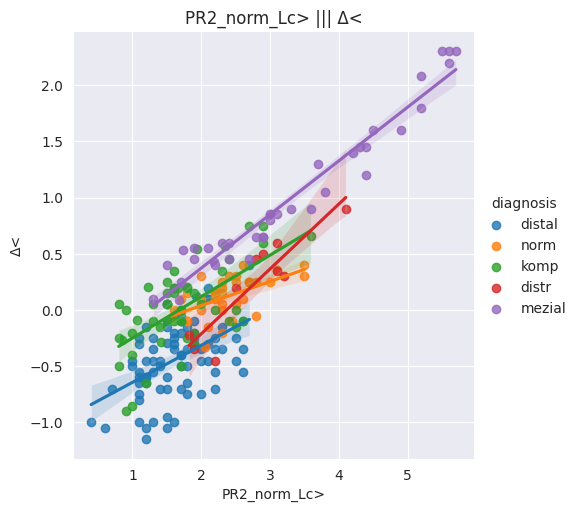

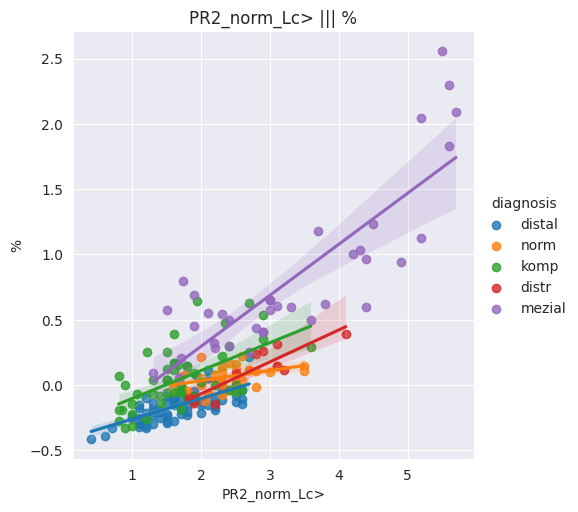

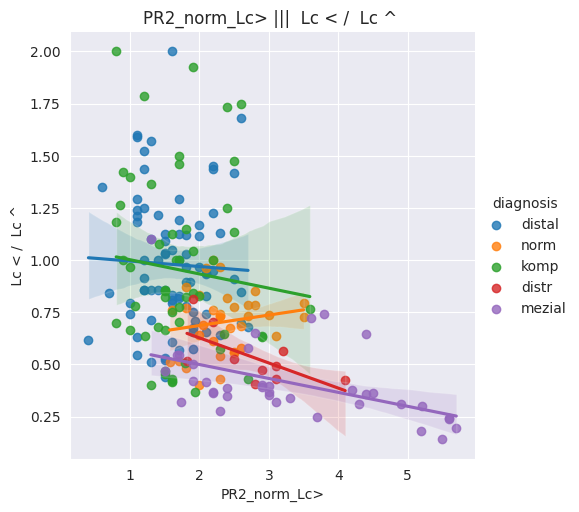

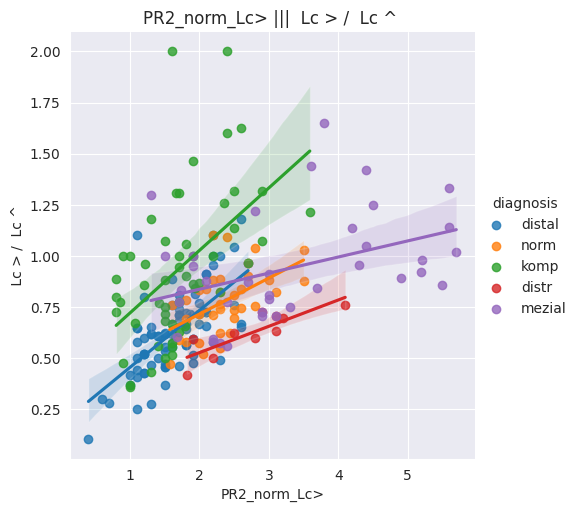

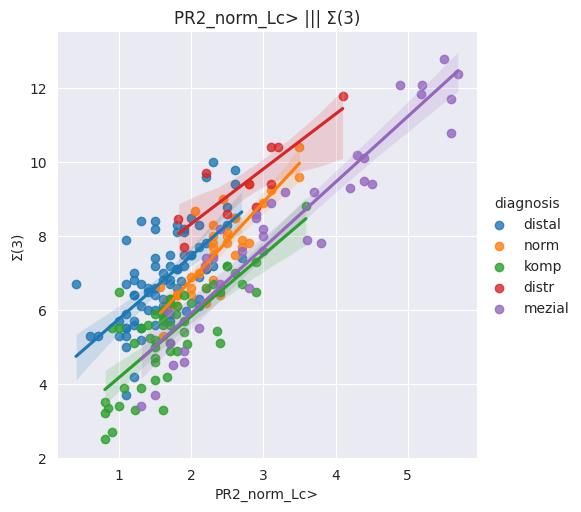

In [ ]:
sns.set_style('darkgrid')   # style = ['darkgrid', 'whitegrid', 'dark', 'white']
sir = 2                     # анализируем все столбцы относительно sir
sir_an = li[sir:]
print(sir_an)
for e in range((len(sir_an)-2)):
  el = e + 3
  sns.lmplot(data=df_irsa, x=df_irsa.columns[sir], y=df_irsa.columns[el], hue='diagnosis') # df.columns[0] - это значения столбика sepal length
                                                                                           # df.columns[1] - это значения столбика sepal width
  title = str(li[sir]+' ||| '+ li[el] )
  plt.title(title)
  plt.show()

### Относитольно третьего "PR2_norm_Lc^" столбца

['PR2_norm_Lc^', 'Σ/2 / Lc^', 'Σ/2', 'Δ<', '%', ' Lc < /  Lc ^ ', ' Lc > /  Lc ^ ', 'Σ(3)', 'diagnosis']


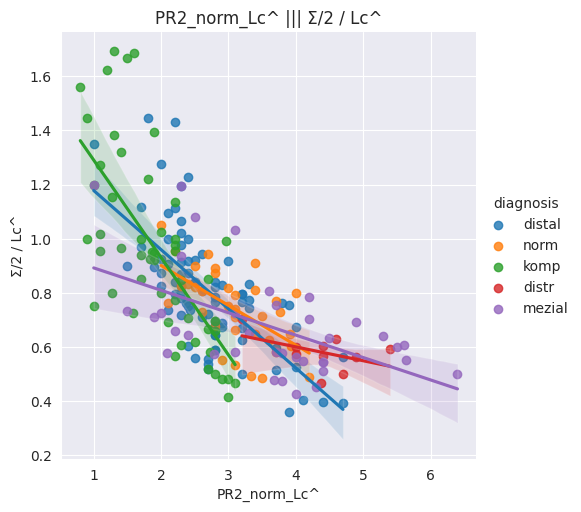

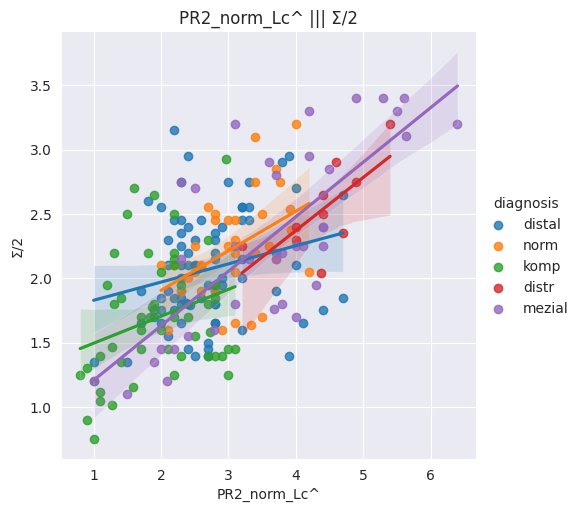

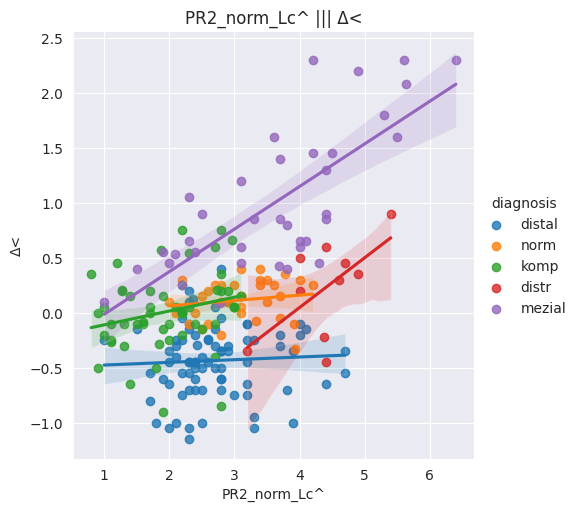

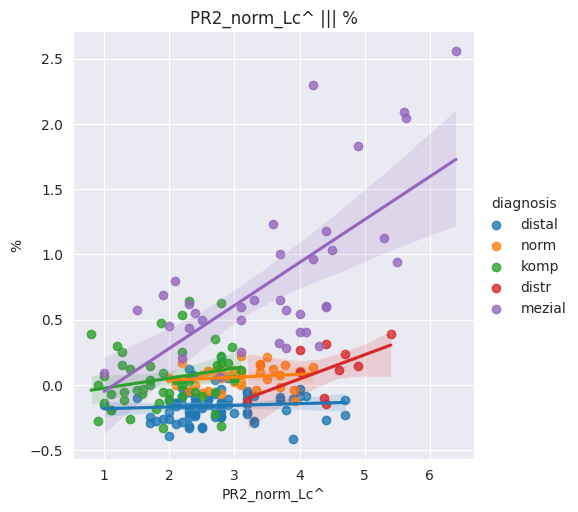

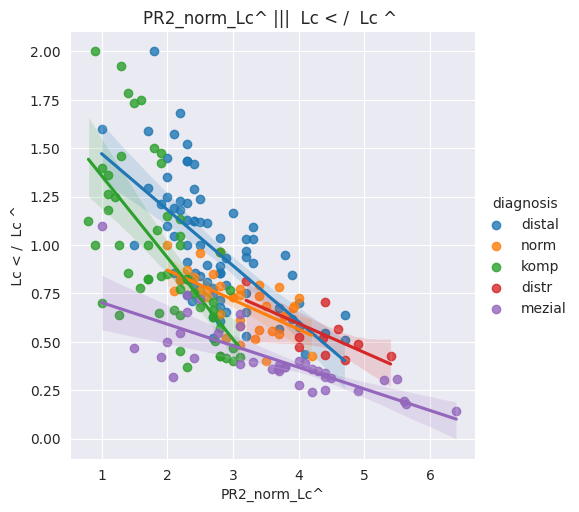

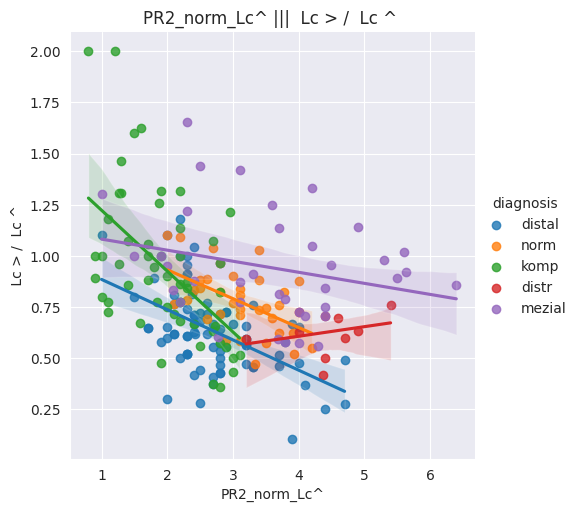

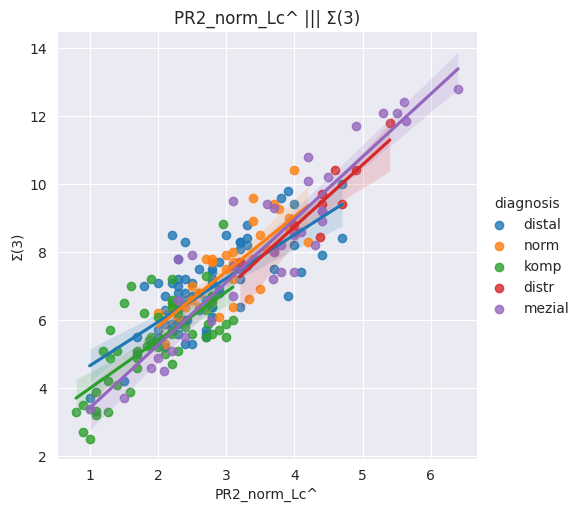

In [ ]:
sns.set_style('darkgrid')   # style = ['darkgrid', 'whitegrid', 'dark', 'white']
sir = 3                     # анализируем все столбцы относительно sir
sir_an = li[sir:]
print(sir_an)
for e in range((len(sir_an)-2)):
  el = e + 4
  sns.lmplot(data=df_irsa, x=df_irsa.columns[sir], y=df_irsa.columns[el], hue='diagnosis') # df.columns[0] - это значения столбика sepal length
                                                                                           # df.columns[1] - это значения столбика sepal width
  title = str(li[sir]+' ||| '+ li[el] )
  plt.title(title)
  plt.show()

### Относитольно четвертого "'Σ/2 / Lc^'" столбца

['Σ/2 / Lc^', 'Σ/2', 'Δ<', '%', ' Lc < /  Lc ^ ', ' Lc > /  Lc ^ ', 'Σ(3)', 'diagnosis']


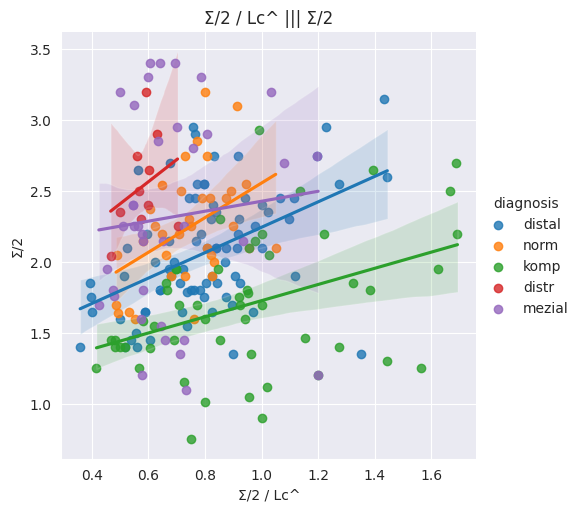

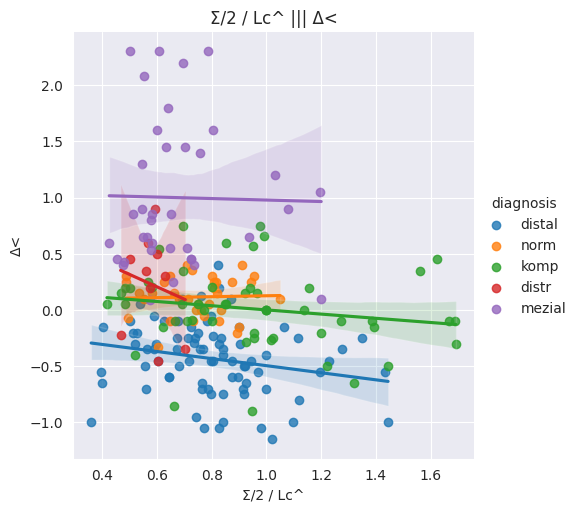

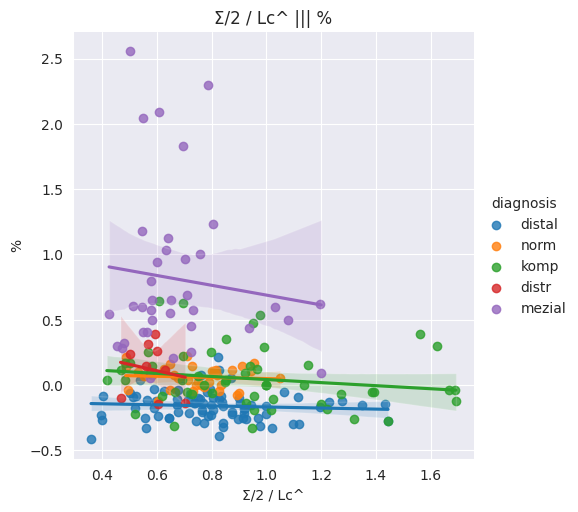

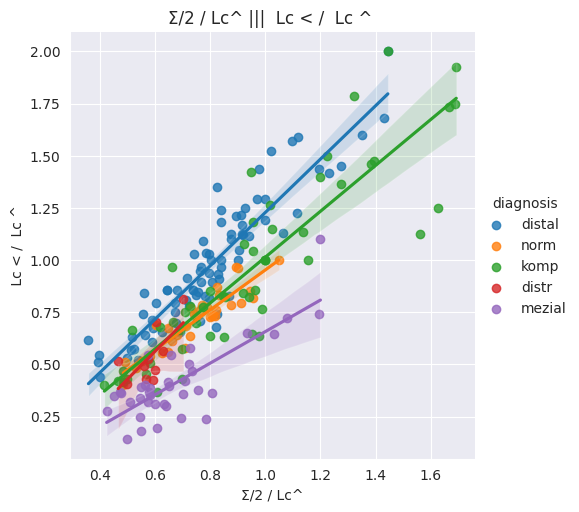

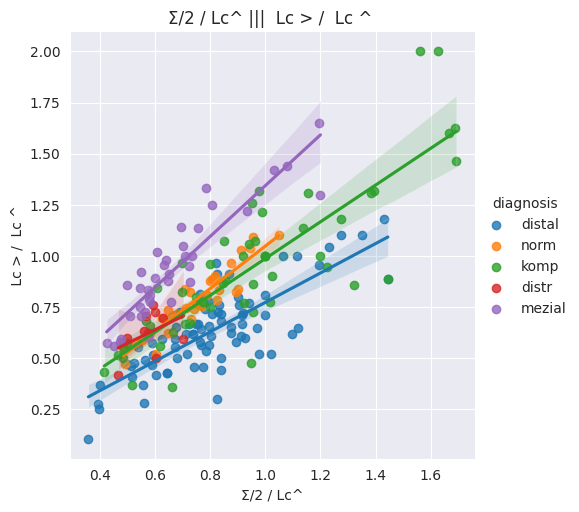

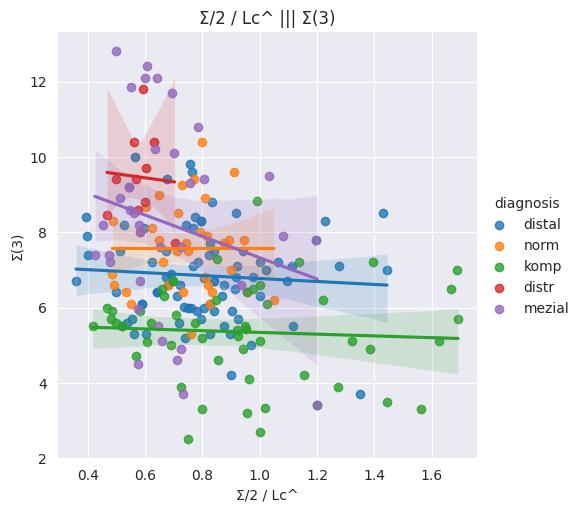

In [ ]:
sns.set_style('darkgrid')   # style = ['darkgrid', 'whitegrid', 'dark', 'white']
sir = 4                     # анализируем все столбцы относительно sir
sir_an = li[sir:]
print(sir_an)
for e in range((len(sir_an)-2)):
  el = e + 5
  sns.lmplot(data=df_irsa, x=df_irsa.columns[sir], y=df_irsa.columns[el], hue='diagnosis') # df.columns[0] - это значения столбика sepal length
                                                                                           # df.columns[1] - это значения столбика sepal width
  title = str(li[sir]+' ||| '+ li[el] )
  plt.title(title)
  plt.show()

### Относитольно пятого "'Σ/2'" столбца

['Σ/2', 'Δ<', '%', ' Lc < /  Lc ^ ', ' Lc > /  Lc ^ ', 'Σ(3)', 'diagnosis']


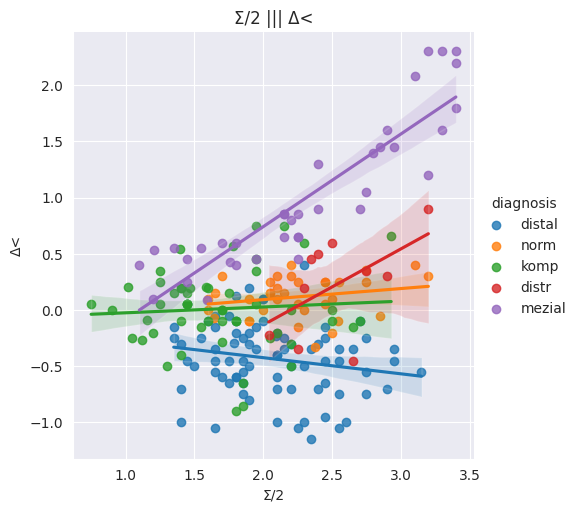

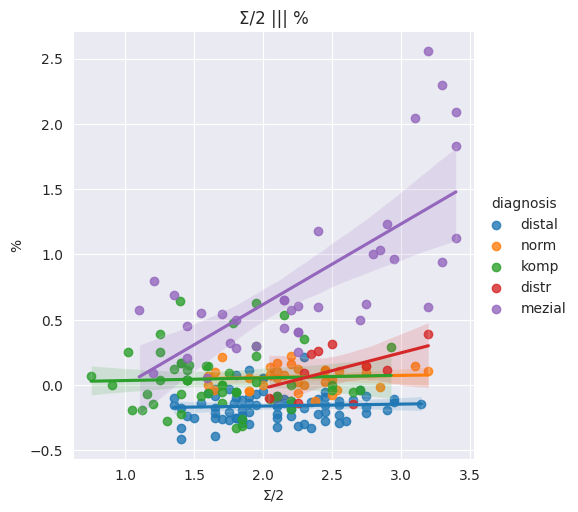

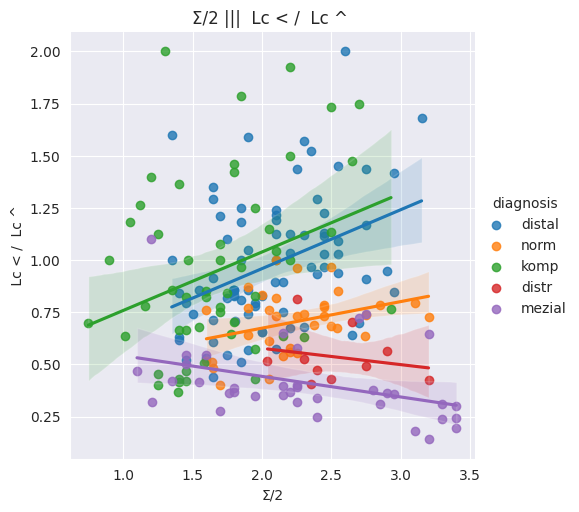

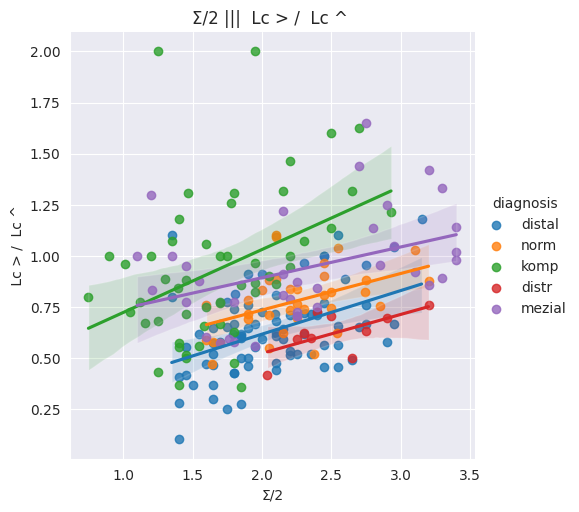

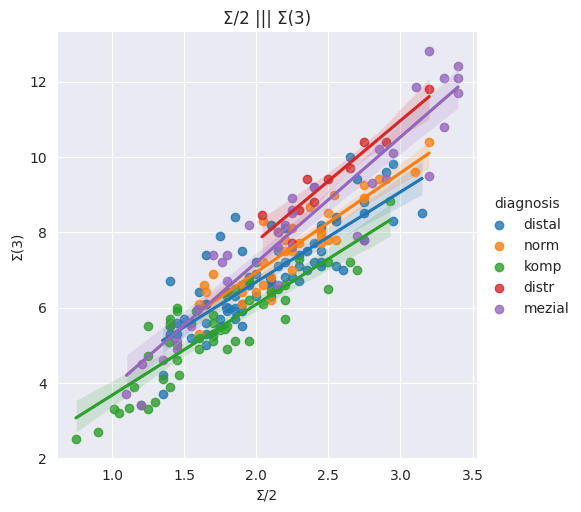

In [ ]:
sns.set_style('darkgrid')   # style = ['darkgrid', 'whitegrid', 'dark', 'white']
sir = 5                     # анализируем все столбцы относительно sir
sir_an = li[sir:]
print(sir_an)
for e in range((len(sir_an)-2)):
  el = e + 6
  sns.lmplot(data=df_irsa, x=df_irsa.columns[sir], y=df_irsa.columns[el], hue='diagnosis') # df.columns[0] - это значения столбика sepal length
                                                                                           # df.columns[1] - это значения столбика sepal width
  title = str(li[sir]+' ||| '+ li[el] )
  plt.title(title)
  plt.show()

### Относитольно шестого "Δ<" столбца

['Δ<', '%', ' Lc < /  Lc ^ ', ' Lc > /  Lc ^ ', 'Σ(3)', 'diagnosis']


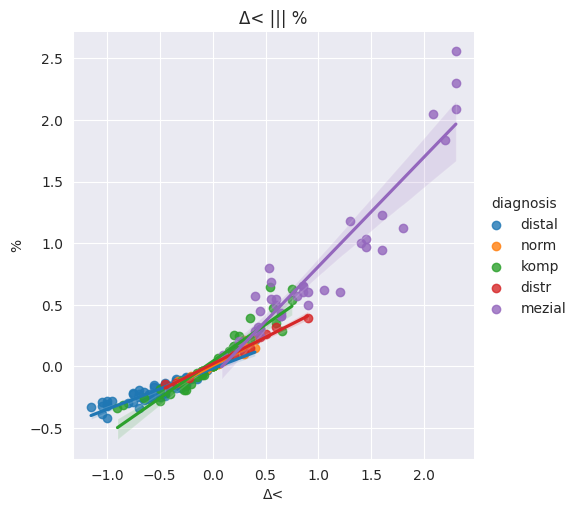

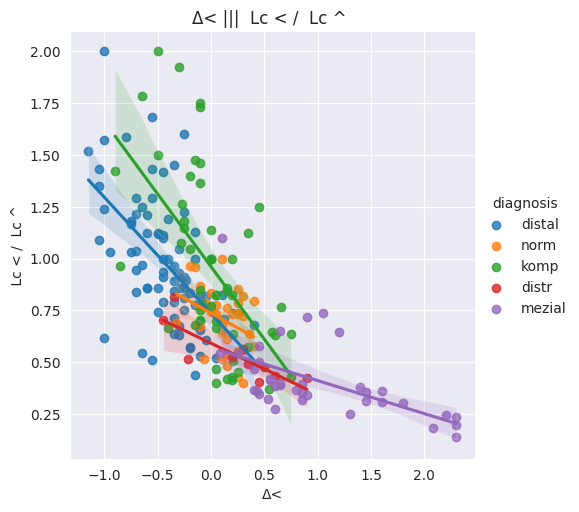

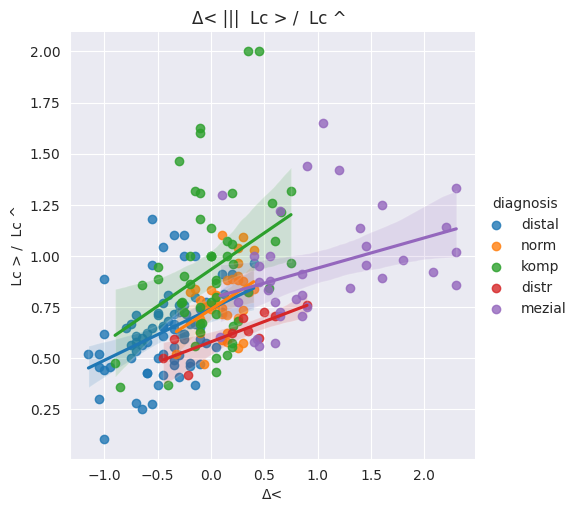

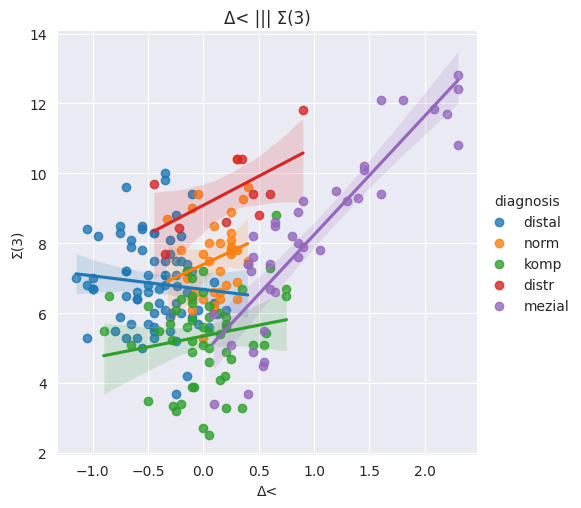

In [ ]:
sns.set_style('darkgrid')   # style = ['darkgrid', 'whitegrid', 'dark', 'white']
sir = 6                     # анализируем все столбцы относительно sir
sir_an = li[sir:]
print(sir_an)
for e in range((len(sir_an)-2)):
  el = e + 7
  sns.lmplot(data=df_irsa, x=df_irsa.columns[sir], y=df_irsa.columns[el], hue='diagnosis') # df.columns[0] - это значения столбика sepal length
                                                                                           # df.columns[1] - это значения столбика sepal width
  title = str(li[sir]+' ||| '+ li[el] )
  plt.title(title)
  plt.show()

### Относитольно седьмого "%" столбца

['%', ' Lc < /  Lc ^ ', ' Lc > /  Lc ^ ', 'Σ(3)', 'diagnosis']


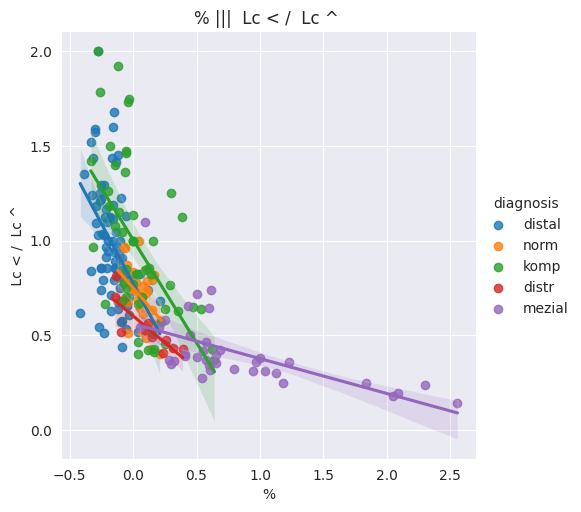

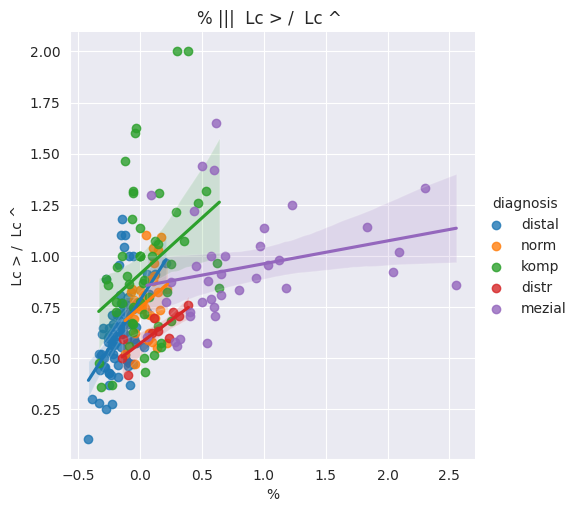

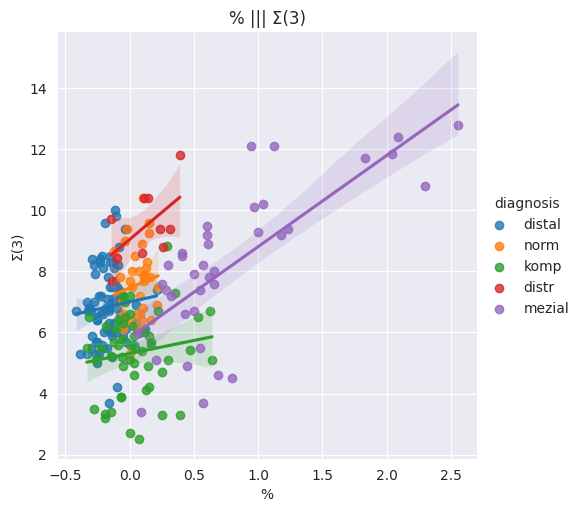

In [ ]:
sns.set_style('darkgrid')   # style = ['darkgrid', 'whitegrid', 'dark', 'white']
sir = 7                     # анализируем все столбцы относительно sir
sir_an = li[sir:]
print(sir_an)
for e in range((len(sir_an)-2)):
  el = e + 8
  sns.lmplot(data=df_irsa, x=df_irsa.columns[sir], y=df_irsa.columns[el], hue='diagnosis') # df.columns[0] - это значения столбика sepal length
                                                                                           # df.columns[1] - это значения столбика sepal width
  title = str(li[sir]+' ||| '+ li[el] )
  plt.title(title)
  plt.show()

### Относитольно восьмого " Lc </Lc^ " столбца

[' Lc < /  Lc ^ ', ' Lc > /  Lc ^ ', 'Σ(3)', 'diagnosis']


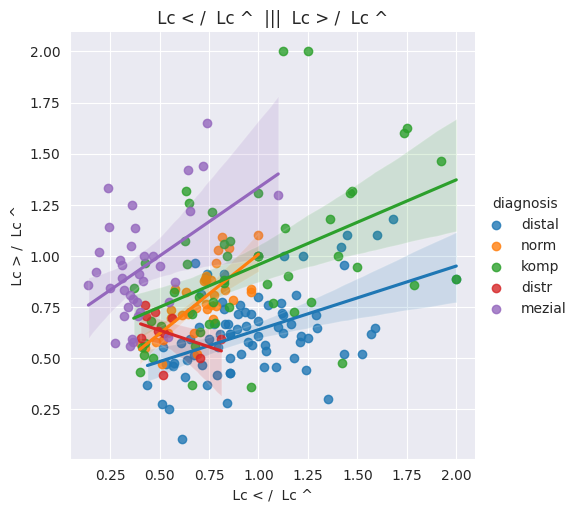

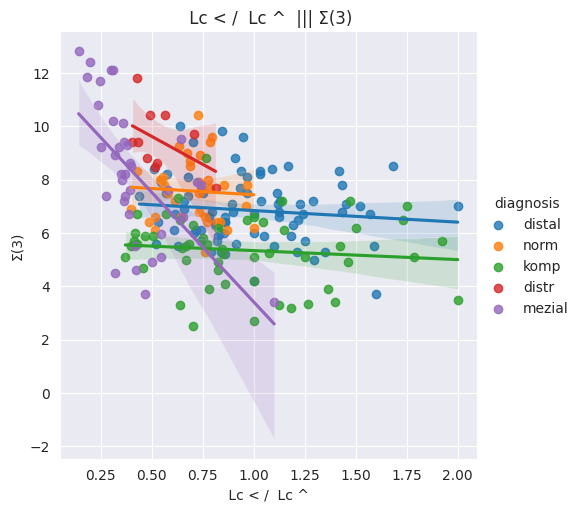

In [ ]:
sns.set_style('darkgrid')   # style = ['darkgrid', 'whitegrid', 'dark', 'white']
sir = 8                     # анализируем все столбцы относительно sir
sir_an = li[sir:]
print(sir_an)
for e in range((len(sir_an)-2)):
  el = e + 9
  sns.lmplot(data=df_irsa, x=df_irsa.columns[sir], y=df_irsa.columns[el], hue='diagnosis') # df.columns[0] - это значения столбика sepal length
                                                                                           # df.columns[1] - это значения столбика sepal width
  title = str(li[sir]+' ||| '+ li[el] )
  plt.title(title)
  plt.show()

### Относитольно девятого "  Lc > /  Lc  " столбца

[' Lc > /  Lc ^ ', 'Σ(3)', 'diagnosis']


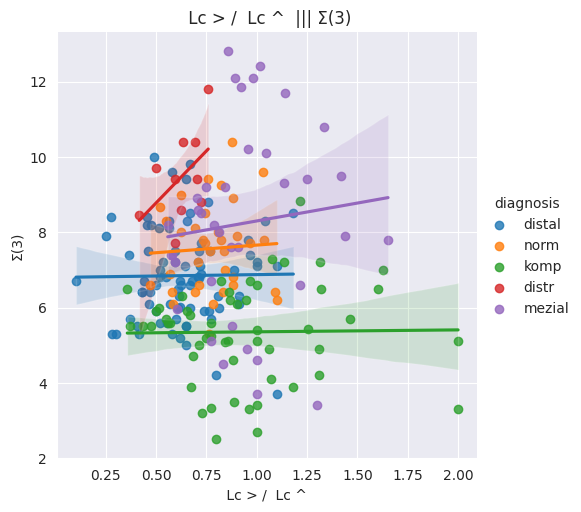

In [ ]:
sns.set_style('darkgrid')   # style = ['darkgrid', 'whitegrid', 'dark', 'white']
sir = 9                     # анализируем все столбцы относительно sir
sir_an = li[sir:]
print(sir_an)
for e in range((len(sir_an)-2)):
  el = e + 10
  sns.lmplot(data=df_irsa, x=df_irsa.columns[sir], y=df_irsa.columns[el], hue='diagnosis') # df.columns[0] - это значения столбика sepal length
                                                                                           # df.columns[1] - это значения столбика sepal width
  title = str(li[sir]+' ||| '+ li[el] )
  plt.title(title)
  plt.show()

### Предпочтительное распределение

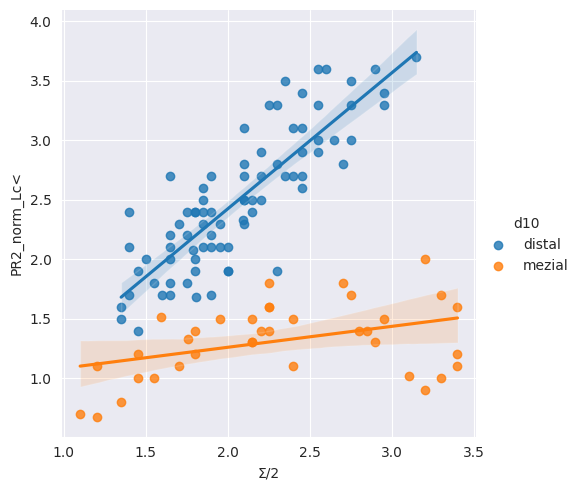

In [12]:
sns.set_style('darkgrid')   # style = ['darkgrid', 'whitegrid', 'dark', 'white']
sir = 5                     # анализируем все столбцы относительно sir
el  = 1
sns.lmplot(data=df_irsa, x=df_irsa.columns[sir], y=df_irsa.columns[el], hue='d10') # df.columns[0] - это значения столбика sepal length
                                                                                        # df.columns[1] - это значения столбика sepal width
#title = str(li[sir]+' ||| '+ li[el] )
#plt.title(title)
plt.show()

### Отображает парные графики всех имеющихся категорий данных по столбцам

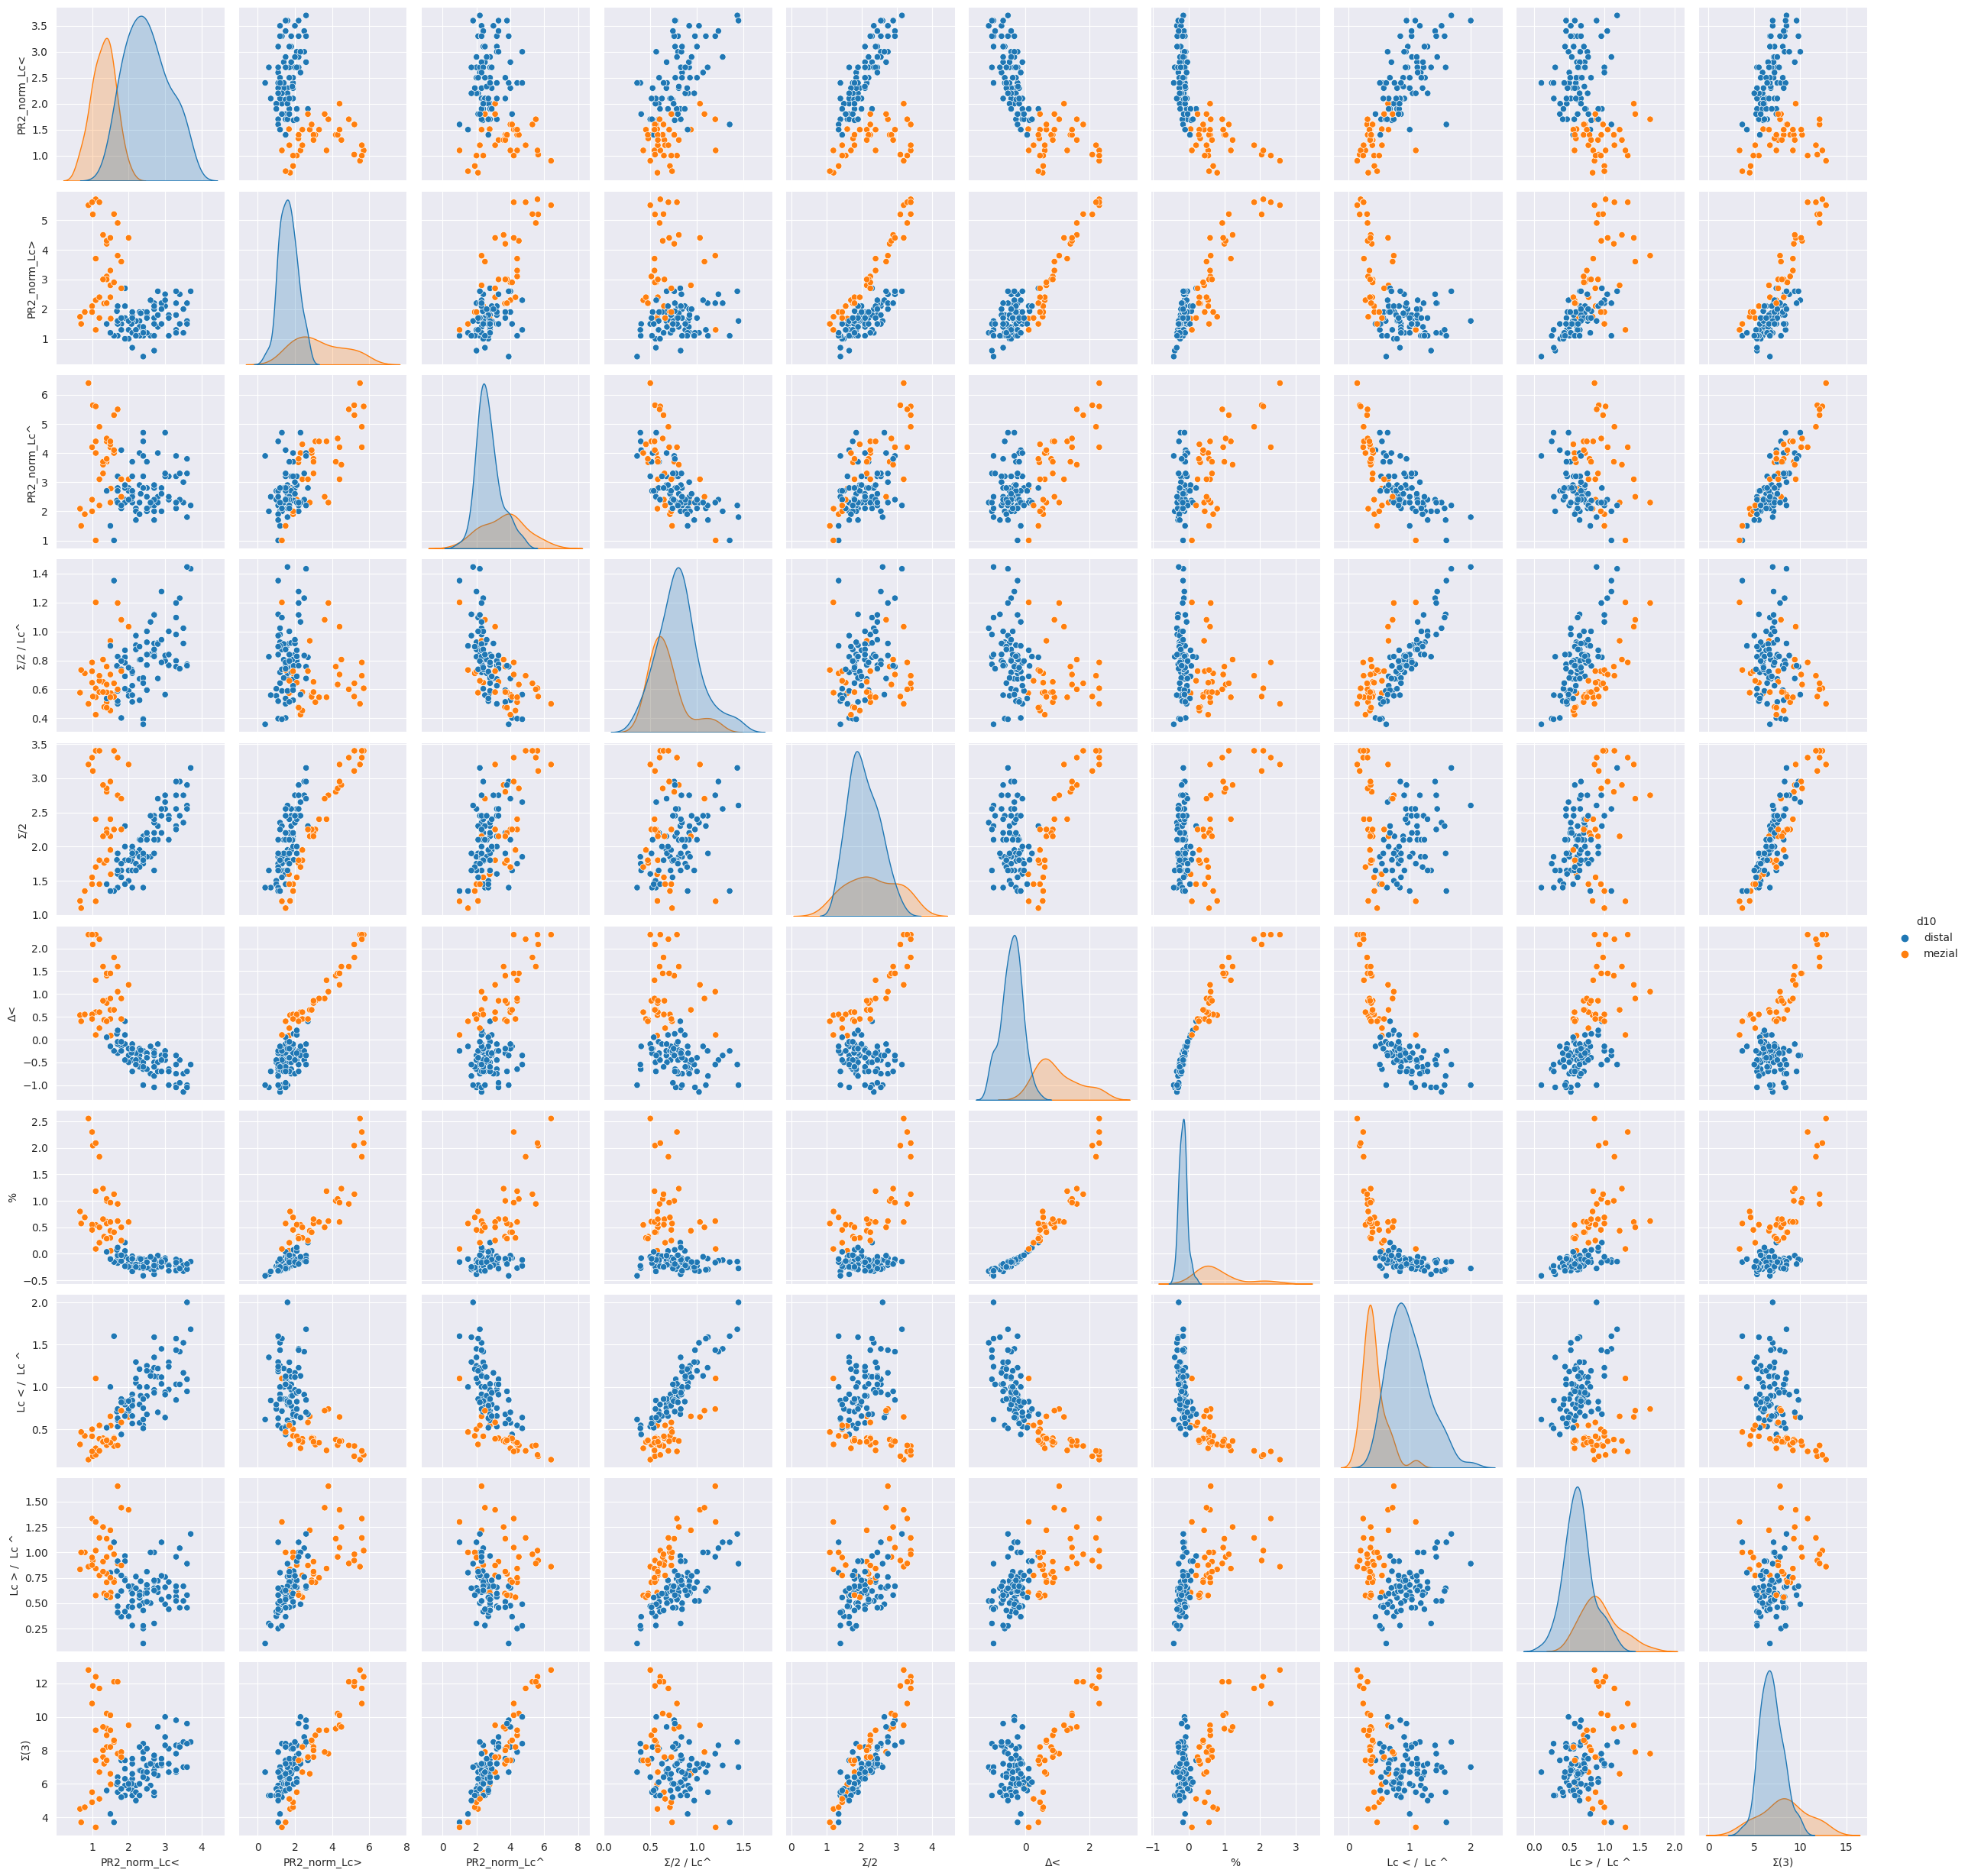

In [27]:
sns.pairplot(df_irsa.drop('ID', axis=1), hue='d10') # отображает парные графики всех имеющихся категорий данных
                                                            # в нашем случае по столбцам
plt.show()

# Анализируем каждый diagnosis

### NORM

(35, 12)


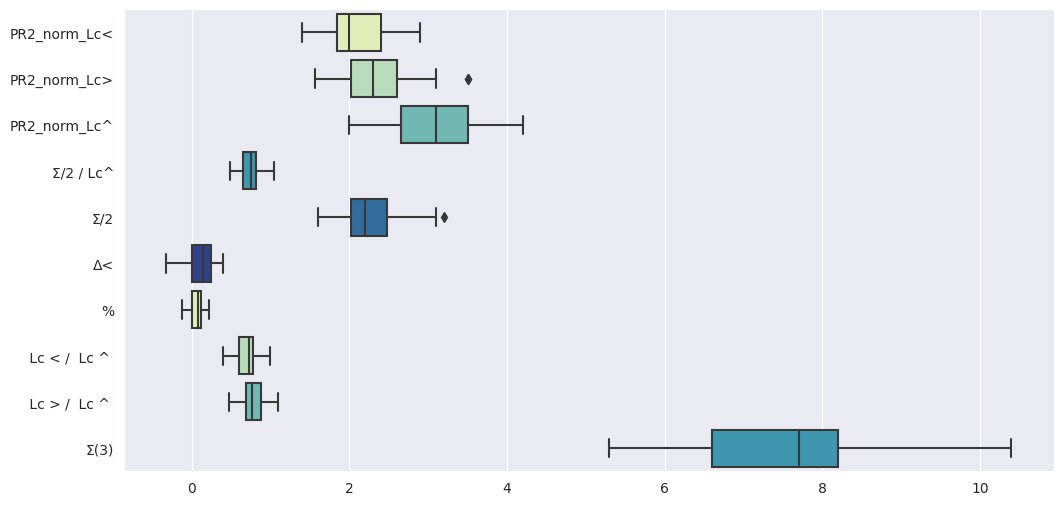

In [ ]:
#задаем маску
mask = df_irsa['diagnosis'] == 'norm'
norm = df_irsa[mask] # Выбираем данные из датафрейма в соответствии с маской и записываем их в новый даатафрейм temp
print(norm.shape)
plt.figure(figsize=(12,6))
sns.boxplot(data=norm.drop('diagnosis', axis=1), palette=sns.color_palette('YlGnBu'), orient='h')
plt.show()

In [ ]:
norm

ID  PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^    Σ/2  \
3       Nw8          2.70          3.50          3.40   0.911765  3.100   
4       Nw9          2.20          2.30          3.00   0.750000  2.250   
5      Nw10          2.20          2.70          3.00   0.816667  2.450   
8      Nw13          2.20          2.70          2.80   0.875000  2.450   
9      Nw14          2.40          2.60          3.50   0.714286  2.500   
11   Nw17__          1.50          1.80          3.10   0.532258  1.650   
12     Nw19          2.00          2.00          2.40   0.833333  2.000   
16     Nw25          2.00          2.50          3.60   0.625000  2.250   
20     Nw29          1.40          2.00          3.50   0.485714  1.700   
21     Nw30          1.60          1.60          2.10   0.761905  1.600   
28     Nw37          1.80          2.30          4.20   0.488095  2.050   
33     Nw42          1.80          2.40          2.20   0.954545  2.100   
38     Nw48          2.00          2.30          3.70   0.581081  2.150   
44     Nw54          2.30          2.30          3.10   0.741935  2.300   
55     Nw68          2.00          1.80          2.60   0.730769  1.900   
63     Nw79          2.70          2.05          3.93   0.604326  2.375   
65     Nw82          2.64          2.44          3.92   0.647959  2.540   
70     Nw88          1.90          2.50          3.40   0.647059  2.200   
74     Nw94          1.90          2.30          2.60   0.807692  2.100   
78     Nw98          1.90          2.20          3.10   0.661290  2.050   
79     Nw99          1.80          2.60          3.10   0.709677  2.200   
84    Nw104          1.50          1.70          2.90   0.551724  1.600   
90    Nw110          1.90          2.20          2.50   0.820000  2.050   
92   Nw113_          2.90          2.80          3.70   0.770270  2.850   
93    Nw114          2.40          2.10          2.50   0.900000  2.250   
138   Nw164          2.00          2.20          2.00   1.050000  2.100   
140   Nw166          2.39          3.10          3.77   0.728117  2.745   
153   Nw179          2.90          3.50          4.00   0.800000  3.200   
162   Nw188          2.30          2.80          2.70   0.944444  2.550   
163   Nw190          2.70          2.30          2.80   0.892857  2.500   
171   Nw205          2.00          1.80          2.30   0.826087  1.900   
175   Nw209          2.50          3.00          3.40   0.808824  2.750   
194   Nw233          1.80          2.00          2.80   0.678571  1.900   
195   Nw234          2.40          2.50          3.10   0.790323  2.450   
208   Nw253          1.71          1.57          3.33   0.492492  1.640   

        Δ<         %   Lc < /  Lc ^    Lc > /  Lc ^    Σ(3) diagnosis  
3    0.400  0.148148        0.794118        1.029412   9.60      norm  
4    0.050  0.022727        0.733333        0.766667   7.50      norm  
5    0.250  0.113636        0.733333        0.900000   7.90      norm  
8    0.250  0.113636        0.785714        0.964286   7.70      norm  
9    0.100  0.041667        0.685714        0.742857   8.50      norm  
11   0.150  0.100000        0.483871        0.580645   6.40      norm  
12   0.000  0.000000        0.833333        0.833333   6.40      norm  
16   0.250  0.125000        0.555556        0.694444   8.10      norm  
20   0.300  0.214286        0.400000        0.571429   6.90      norm  
21   0.000  0.000000        0.761905        0.761905   5.30      norm  
28   0.250  0.138889        0.428571        0.547619   8.30      norm  
33   0.300  0.166667        0.818182        1.090909   6.40      norm  
38   0.150  0.075000        0.540541        0.621622   8.00      norm  
44   0.000  0.000000        0.741935        0.741935   7.70      norm  
55  -0.100 -0.050000        0.769231        0.692308   6.40      norm  
63  -0.325 -0.120370        0.687023        0.521628   8.68      norm  
65  -0.100 -0.037879        0.673469        0.622449   9.00      norm  
70   0.300  

In [ ]:
norm.describe()

PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^        Σ/2  \
count     35.000000      35.00000     35.000000  35.000000  35.000000   
mean       2.124000       2.35600      3.087143   0.740973   2.240000   
std        0.400281       0.47233      0.576432   0.141389   0.399479   
min        1.400000       1.57000      2.000000   0.485714   1.600000   
25%        1.850000       2.02500      2.650000   0.647509   2.025000   
50%        2.000000       2.30000      3.100000   0.750000   2.200000   
75%        2.400000       2.60000      3.500000   0.823043   2.475000   
max        2.900000       3.50000      4.200000   1.050000   3.200000   

              Δ<          %   Lc < /  Lc ^    Lc > /  Lc ^        Σ(3)  
count  35.000000  35.000000       35.000000       35.000000  35.000000  
mean    0.116000   0.060105        0.704015        0.777932   7.567143  
std     0.179098   0.084543        0.146881        0.157825   1.174162  
min    -0.325000  -0.120370        0.400000        0.471471   5.300000  
25%     0.000000   0.000000        0.596774        0.693376   6.600000  
50%     0.150000   0.075000        0.733333        0.766667   7.700000  
75%     0.250000   0.113636        0.784749        0.877500   8.200000  
max     0.400000   0.222222        1.000000        1.100000  10.400000

Всего  5 выбросов
Заключение:

Nw196 - 2 выброса   %, >,    
Nw  3 -   1 выброс    Σ/2, >

Nw111 - 1 выброс    Δ<    

## KOMP

(52, 15)


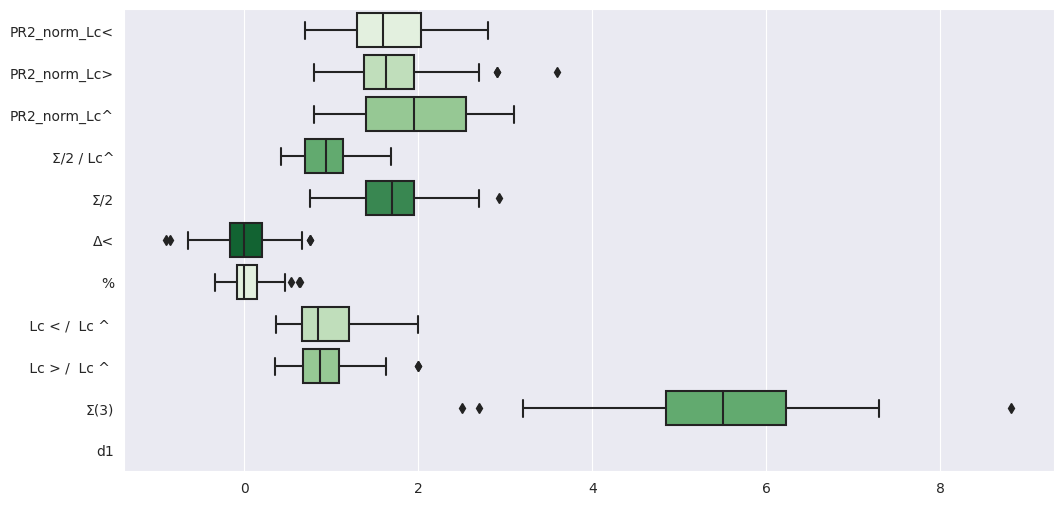

In [ ]:
#задаем маску
mask = df_irsa['d3'] == 'komp'
komp = df_irsa[mask] # Выбираем данные из датафрейма в соответствии с маской и записываем их в новый даатафрейм temp
print(komp.shape)
plt.figure(figsize=(12,6))
sns.boxplot(data=komp.drop('diagnosis', axis=1), palette=sns.color_palette('Greens'), orient='h')
plt.show()


In [ ]:
komp[:30]

ID  PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^    Σ/2  \
10     Nw15          2.70          1.70          1.80   1.222222  2.200   
13     Nw21          0.90          1.60          0.80   1.562500  1.250   
19     Nw28          1.20          1.60          2.90   0.482759  1.400   
23     Nw32          2.50          1.20          1.40   1.321429  1.850   
24     Nw33          2.50          1.90          1.30   1.692308  2.200   
25     Nw34          0.70          0.80          1.00   0.750000  0.750   
26     Nw35          1.70          1.50          2.00   0.800000  1.600   
30     Nw39          1.40          1.50          3.00   0.483333  1.450   
34     Nw43          2.80          2.50          1.90   1.394737  2.650   
39     Nw49          1.20          1.60          2.80   0.500000  1.400   
48     Nw58          1.90          1.70          1.30   1.384615  1.800   
49     Nw59          1.38          1.79          2.73   0.580586  1.585   
54     Nw67          1.80          0.80          0.90   1.444444  1.300   
58    Nw73x          2.27          3.59          2.96   0.989865  2.930   
64     Nw81          1.70          1.70          2.20   0.772727  1.700   
66     Nw83          1.80          1.00          2.70   0.518519  1.400   
67     Nw84          0.90          0.90          0.90   1.000000  0.900   
69     Nw86          1.80          1.60          2.40   0.708333  1.700   
72     Nw92          1.90          1.70          2.70   0.666667  1.800   
80    Nw100          2.30          1.90          2.20   0.954545  2.100   
82    Nw102          2.50          2.50          2.20   1.136364  2.500   
88    Nw108          2.70          0.90          1.90   0.947368  1.800   
89    Nw109          2.70          1.00          2.80   0.660714  1.850   
91    Nw112          2.30          1.80          2.00   1.025000  2.050   
98    Nw119          1.24          1.07          1.59   0.726415  1.155   
99   Nw120_          1.21          2.35          1.87   0.951872  1.780   
101   Nw123          0.85          1.94          2.30   0.606522  1.395   
110   Nw132          1.40          1.80          1.70   0.941176  1.600   
111   Nw133          1.60          1.90          1.90   0.921053  1.750   
114   Nw136          1.40          1.50          1.70   0.852941  1.450   

        Δ<         %   Lc < /  Lc ^    Lc > /  Lc ^   Σ(3) diagnosis   d1  \
10  -0.500 -0.185185        1.500000        0.944444  6.20      komp  NaN   
13   0.350  0.388889        1.125000        2.000000  3.30      komp  NaN   
19   0.200  0.166667        0.413793        0.551724  5.70      komp  NaN   
23  -0.650 -0.260000        1.785714        0.857143  5.10      komp  NaN   
24  -0.300 -0.120000        1.923077        1.461538  5.70      komp  NaN   
25   0.050  0.071429        0.700000        0.800000  2.50      komp  NaN   
26  -0.100 -0.058824        0.850000        0.750000  5.20      komp  NaN   
30   0.050  0.035714        0.466667        0.500000  5.90      komp  NaN   
34  -0.150 -0.053571        1.473684        1.315789  7.20      komp  NaN   
39   0.200  0.166667        0.428571        0.571429  5.60      komp  NaN   
48  -0.100 -0.052632        1.461538        1.307692  4.90      komp  NaN   
49   0.205  0.148551        0.505495        0.655678  5.90      komp  NaN   
54  -0.500 -0.277778        2.000000        0.888889  3.50      komp  NaN   
58   0.660  0.290749        0.766892        1.212838  8.82      komp  NaN   
64   0.000  0.000000        0.772727        0.772727  5.60      komp  NaN   
66  -0.400 -0.222222        0.666667        0.370370  5.50      komp  NaN   
67   0.000  0.000000        1.000000        1.000000  2.70      komp  NaN   
69  -0.100 -0.055556        0.750000        0.666667  5.80      komp  NaN   
72  -0.100 -0.052632        0.703704        0.629630  6.30      komp  NaN   
80  -0.200 -0.086957        1.045455        0.863636  6.40      komp  NaN   
82   0.000  0.000000        1.136364        1.136364  7.20      ko

In [ ]:
komp[30:]

ID  PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^    Σ/2     Δ<  \
123  Nw146          1.00          1.50          2.20   0.568182  1.250  0.250   
124  Nw147          1.70          2.90          2.70   0.851852  2.300  0.600   
128  Nw152          1.50          2.40          1.20   1.625000  1.950  0.450   
130  Nw154          2.20          2.20          2.20   1.000000  2.200  0.000   
134  Nw158          1.30          0.80          1.10   0.954545  1.050 -0.250   
139  Nw165          1.98          1.42          1.84   0.923913  1.700 -0.280   
142  Nw168          0.81          1.22          1.27   0.799213  1.015  0.205   
147  Nw173          1.20          1.50          1.40   0.964286  1.350  0.150   
151  Nw177          1.20          2.70          2.80   0.696429  1.950  0.750   
172  Nw206          1.70          1.70          1.70   1.000000  1.700  0.000   
176  Nw210          2.60          2.40          1.50   1.666667  2.500 -0.100   
177  Nw211          2.80          2.60          1.60   1.687500  2.700 -0.100   
189  Nw224          1.27          1.66          1.27   1.153543  1.465  0.195   
190  Nw226          1.39          0.85          1.10   1.018182  1.120 -0.270   
198  Nw237          1.40          1.50          2.10   0.690476  1.450  0.050   
199  Nw239          1.40          2.90          2.20   0.977273  2.150  0.750   
201  Nw241          1.90          2.00          2.30   0.847826  1.950  0.050   
207  Nw252          1.70          1.40          2.50   0.620000  1.550 -0.150   
209  Nw254          1.20          1.30          3.00   0.416667  1.250  0.050   
210  Nw255          1.30          1.60          3.10   0.467742  1.450  0.150   
211  Nw257          1.50          1.30          1.10   1.272727  1.400 -0.100   
212  Nw260          1.40          1.00          1.00   1.200000  1.200 -0.200   
213  Nw261          1.60          2.30          2.80   0.696429  1.950  0.350   

            %   Lc < /  Lc ^    Lc > /  Lc ^   Σ(3) diagnosis  
123  0.250000        0.454545        0.681818  4.70      komp  
124  0.352941        0.629630        1.074074  7.30      komp  
128  0.300000        1.250000        2.000000  5.10      komp  
130  0.000000        1.000000        1.000000  6.60      komp  
134 -0.192308        1.181818        0.727273  3.20      komp  
139 -0.141414        1.076087        0.771739  5.24      komp  
142  0.253086        0.637795        0.960630  3.30      komp  
147  0.125000        0.857143        1.071429  4.10      komp  
151  0.625000        0.428571        0.964286  6.70      komp  
172  0.000000        1.000000        1.000000  5.10      komp  
176 -0.038462        1.733333        1.600000  6.50      komp  
177 -0.035714        1.750000        1.625000  7.00      komp  
189  0.153543        1.000000        1.307087  4.20      komp  
190 -0.194245        1.263636        0.772727  3.34      komp  
198  0.035714        0.666667        0.714286  5.00      komp  
199  0.535714        0.636364        1.318182  6.50      komp  
201  0.026316        0.826087        0.869565  6.20      komp  
207 -0.088235        0.680000        0.560000  5.60      komp  
209  0.041667        0.400000        0.433333  5.50      komp  
210  0.115385        0.419355        0.516129  6.00      komp  
211 -0.066667        1.363636        1.181818  3.90      komp  
212 -0.142857        1.400000        1.000000  3.40      komp  
213  0.218750        0.571429        0.821429  6.70      komp

In [ ]:
komp.describe()

PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^        Σ/2  \
count     53.000000     53.000000     53.000000  53.000000  53.000000   
mean       1.684906      1.707358      1.959057   0.945235   1.696132   
std        0.571619      0.610914      0.663789   0.340008   0.473228   
min        0.700000      0.800000      0.800000   0.416667   0.750000   
25%        1.270000      1.300000      1.400000   0.696429   1.400000   
50%        1.600000      1.600000      1.900000   0.941176   1.700000   
75%        1.980000      1.940000      2.500000   1.136364   1.950000   
max        2.800000      3.590000      3.100000   1.692308   2.930000   

              Δ<          %   Lc < /  Lc ^    Lc > /  Lc ^        Σ(3)  
count  53.000000  53.000000       53.000000       53.000000  53.000000  
mean    0.011226   0.047843        0.953254        0.937217   5.351321  
std     0.355017   0.223905        0.423994        0.365197   1.305808  
min    -0.900000  -0.333333        0.369565        0.357143   2.500000  
25%    -0.150000  -0.086957        0.647059        0.681818   4.700000  
50%     0.000000   0.000000        0.842105        0.882353   5.500000  
75%     0.200000   0.153543        1.181818        1.074074   6.200000  
max     0.750000   0.641176        2.000000        2.000000   8.820000

## DISTAL

(80, 12)


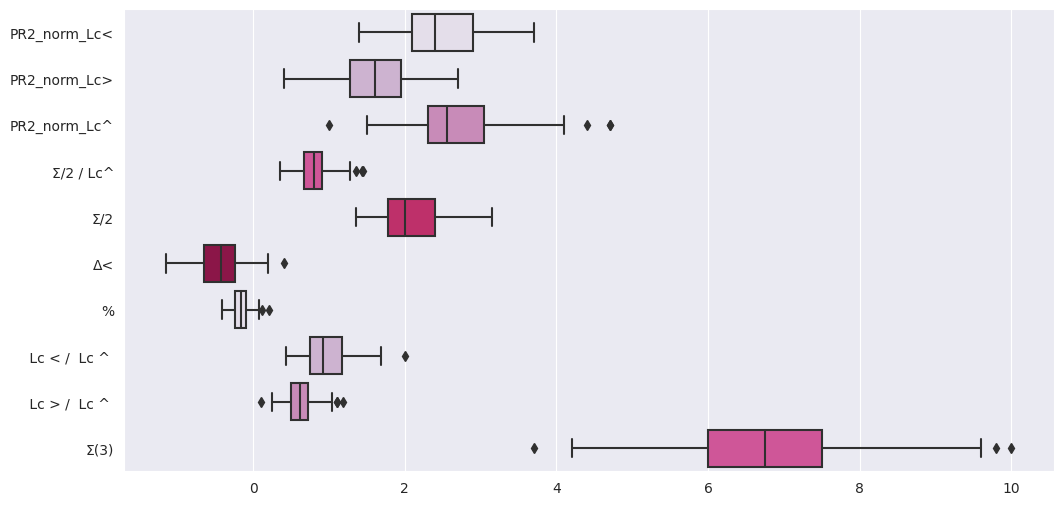

In [ ]:
#задаем маску
mask = df_irsa['diagnosis'] == 'distal'
distal = df_irsa[mask] # Выбираем данные из датафрейма в соответствии с маской и записываем их в новый даатафрейм temp
print(distal.shape)
plt.figure(figsize=(12,6))
sns.boxplot(data=distal.drop('diagnosis', axis=1), palette=sns.color_palette('PuRd'), orient='h')
plt.show()


In [ ]:
distal[:25]

ID  PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^   Σ/2    Δ<  \
0     Nw1          2.30           1.6          2.90   0.672414  1.95 -0.35   
1     Nw2          2.20           1.6          2.10   0.904762  1.90 -0.30   
2     Nw5          1.80           1.5          4.10   0.402439  1.65 -0.15   
6    Nw11          2.40           1.9          3.20   0.671875  2.15 -0.25   
7    Nw12          2.50           1.8          2.80   0.767857  2.15 -0.35   
17   Nw26          3.10           1.8          3.20   0.765625  2.45 -0.65   
18   Nw27          2.00           1.3          2.80   0.589286  1.65 -0.35   
35   Nw44          2.10           1.2          2.30   0.717391  1.65 -0.45   
36   Nw45          2.40           1.2          2.80   0.642857  1.80 -0.60   
40   Nw50          2.40           1.1          4.40   0.397727  1.75 -0.65   
41   Nw51          1.70           1.5          3.20   0.500000  1.60 -0.10   
42   Nw52          2.60           1.1          2.20   0.840909  1.85 -0.75   
43   Nw53          2.70           0.6          2.00   0.825000  1.65 -1.05   
45   Nw55          2.50           1.2          2.00   0.925000  1.85 -0.65   
46   Nw56          2.30           1.4          2.30   0.804348  1.85 -0.45   
47   Nw57          3.00           2.1          3.20   0.796875  2.55 -0.45   
56   Nw69          2.10           1.6          2.60   0.711538  1.85 -0.25   
61  Nw76x          2.08           1.5          2.43   0.736626  1.79 -0.29   
62   Nw77          2.40           1.3          4.70   0.393617  1.85 -0.55   
73   Nw93          2.40           1.4          2.80   0.678571  1.90 -0.50   
75   Nw95          2.00           1.0          2.70   0.555556  1.50 -0.50   
81  Nw101          2.30           1.9          4.00   0.525000  2.10 -0.20   
83  Nw103          2.90           2.2          2.00   1.275000  2.55 -0.35   
85  Nw105          1.70           1.6          2.80   0.589286  1.65 -0.05   
86  Nw106          3.30           1.8          3.20   0.796875  2.55 -0.75   

           %   Lc < /  Lc ^    Lc > /  Lc ^   Σ(3) diagnosis  
0  -0.152174        0.793103        0.551724  6.80    distal  
1  -0.136364        1.047619        0.761905  5.90    distal  
2  -0.083333        0.439024        0.365854  7.40    distal  
6  -0.104167        0.750000        0.593750  7.50    distal  
7  -0.140000        0.892857        0.642857  7.10    distal  
17 -0.209677        0.968750        0.562500  8.10    distal  
18 -0.175000        0.714286        0.464286  6.10    distal  
35 -0.214286        0.913043        0.521739  5.60    distal  
36 -0.250000        0.857143        0.428571  6.40    distal  
40 -0.270833        0.545455        0.250000  7.90    distal  
41 -0.058824        0.531250        0.468750  6.40    distal  
42 -0.288462        1.181818        0.500000  5.90    distal  
43 -0.388889        1.350000        0.300000  5.30    distal  
45 -0.260000        1.250000        0.600000  5.70    distal  
46 -0.195652        1.000000        0.608696  6.00    distal  
47 -0.150000        0.937500        0.656250  8.30    distal  
56 -0.119048        0.807692        0.615385  6.30    distal  
61 -0.139423        0.855967        0.617284  6.01    distal  
62 -0.229167        0.510638        0.276596  8.40    distal  
73 -0.208333        0.857143        0.500000  6.60    distal  
75 -0.250000        0.740741        0.370370  5.70    distal  
81 -0.086957        0.575000        0.475000  8.20    distal  
83 -0.120690        1.450000        1.100000  7.10    distal  
85 -0.029412        0.607143        0.571429  6.10    distal  
86 -0.227273        1.031250        0.562500  8.30    distal

In [ ]:
distal[25:50]

ID  PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^    Σ/2  \
95   Nw116__          2.70          1.70          2.40   0.916667  2.200   
97    Nw118_          3.50          1.20          2.30   1.021739  2.350   
100   Nw122_          2.10          0.70          2.50   0.560000  1.400   
102    Nw124          2.70          1.10          1.70   1.117647  1.900   
103    Nw125          3.30          1.30          2.10   1.095238  2.300   
104    Nw126          2.70          2.20          2.20   1.113636  2.450   
108    Nw130          1.90          2.70          2.80   0.821429  2.300   
109    Nw131          2.80          1.80          2.50   0.920000  2.300   
112    Nw134          2.20          1.30          2.00   0.875000  1.750   
113    Nw135          2.70          2.00          2.80   0.839286  2.350   
115   Nw137_          1.90          1.00          2.40   0.604167  1.450   
116    Nw138          2.80          1.40          2.30   0.913043  2.100   
118   Nw141_          1.90          1.70          2.30   0.782609  1.800   
119   Nw142_          2.33          1.86          2.60   0.805769  2.095   
120    Nw143          1.68          1.93          2.37   0.761603  1.805   
121    Nw144          2.10          1.80          2.70   0.722222  1.950   
122    Nw145          2.40          0.40          3.90   0.358974  1.400   
126    Nw150          3.30          1.20          2.30   0.978261  2.250   
127   Nw151_          1.90          2.10          2.30   0.869565  2.000   
129    Nw153          2.10          1.90          3.20   0.625000  2.000   
132    Nw156          2.50          1.90          3.70   0.594595  2.200   
135    Nw159          3.00          2.50          3.30   0.833333  2.750   
136    Nw160          2.50          1.70          2.50   0.840000  2.100   
137    Nw161          3.10          1.70          2.40   1.000000  2.400   
141    Nw167          1.70          1.10          2.70   0.518519  1.400   

        Δ<         %   Lc < /  Lc ^    Lc > /  Lc ^   Σ(3) diagnosis  
95  -0.500 -0.185185        1.125000        0.708333  6.80    distal  
97  -1.150 -0.328571        1.521739        0.521739  7.00    distal  
100 -0.700 -0.333333        0.840000        0.280000  5.30    distal  
102 -0.800 -0.296296        1.588235        0.647059  5.50    distal  
103 -1.000 -0.303030        1.571429        0.619048  6.70    distal  
104 -0.250 -0.092593        1.227273        1.000000  7.10    distal  
108  0.400  0.210526        0.678571        0.964286  7.40    distal  
109 -0.500 -0.178571        1.120000        0.720000  7.10    distal  
112 -0.450 -0.204545        1.100000        0.650000  5.50    distal  
113 -0.350 -0.129630        0.964286        0.714286  7.50    distal  
115 -0.450 -0.236842        0.791667        0.416667  5.30    distal  
116 -0.700 -0.250000        1.217391        0.608696  6.50    distal  
118 -0.100 -0.052632        0.826087        0.739130  5.90    distal  
119 -0.235 -0.100858        0.896154        0.715385  6.79    distal  
120  0.125  0.074405        0.708861        0.814346  5.98    distal  
121 -0.150 -0.071429        0.777778        0.666667  6.60    distal  
122 -1.000 -0.416667        0.615385        0.102564  6.70    distal  
126 -1.050 -0.318182        1.434783        0.521739  6.80    distal  
127  0.100  0.052632        0.826087        0.913043  6.30    distal  
129 -0.100 -0.047619        0.656250        0.593750  7.20    distal  
132 -0.300 -0.120000        0.675676        0.513514  8.10    distal  
135 -0.250 -0.083333        0.909091        0.757576  8.80    distal  
136 -0.400 -0.160000        1.000000        0.680000  6.70    distal  
137 -0.700 -0.225806        1.291667        0.708333  7.20    distal  
141 -0.300 -0.176471        0.629630        0.407407  5.50    distal

In [ ]:
distal[50:]

ID  PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^   Σ/2    Δ<  \
143  Nw169           1.9           2.1           2.9   0.689655  2.00  0.10   
144  Nw170           1.6           1.1           1.0   1.350000  1.35 -0.25   
145  Nw171           3.0           2.3           4.7   0.563830  2.65 -0.35   
148  Nw174           2.8           2.6           4.0   0.675000  2.70 -0.10   
149  Nw175           1.4           1.5           2.7   0.537037  1.45  0.05   
150  Nw176           1.7           2.1           2.3   0.826087  1.90  0.20   
152  Nw178           1.8           1.3           2.1   0.738095  1.55 -0.25   
154  Nw180           3.4           2.5           2.4   1.229167  2.95 -0.45   
156  Nw182           1.5           1.2           1.5   0.900000  1.35 -0.15   
158  Nw184           3.3           2.6           3.9   0.756410  2.95 -0.35   
160  Nw186           2.0           1.6           2.4   0.750000  1.80 -0.20   
164  Nw192           3.7           2.6           2.2   1.431818  3.15 -0.55   
166  Nw195           2.1           1.7           3.7   0.513514  1.90 -0.20   
168  Nw199           3.6           1.6           1.8   1.444444  2.60 -1.00   
169  Nw201           2.7           2.1           2.9   0.827586  2.40 -0.30   
170  Nw204           3.5           2.0           3.0   0.916667  2.75 -0.75   
173  Nw207           3.6           1.5           3.3   0.772727  2.55 -1.05   
174  Nw208           2.3           1.1           1.9   0.894737  1.70 -0.60   
178  Nw212           2.7           1.5           2.4   0.875000  2.10 -0.60   
179  Nw213           2.9           1.5           2.8   0.785714  2.20 -0.70   
183  Nw217           3.4           1.5           3.3   0.742424  2.45 -0.95   
188  Nw223           2.6           2.3           2.3   1.065217  2.45 -0.15   
191  Nw229           2.2           1.1           1.7   0.970588  1.65 -0.55   
197  Nw236           1.8           1.7           2.2   0.795455  1.75 -0.05   
200  Nw240           2.5           1.7           2.1   1.000000  2.10 -0.40   
202  Nw243           3.3           2.2           2.3   1.195652  2.75 -0.55   
203  Nw246           2.9           2.0           2.6   0.942308  2.45 -0.45   
204  Nw247           3.6           2.2           3.8   0.763158  2.90 -0.70   
205  Nw249           2.4           1.2           2.8   0.642857  1.80 -0.60   
214  Nw263           3.1           1.1           2.5   0.840000  2.10 -1.00   

            %   Lc < /  Lc ^    Lc > /  Lc ^   Σ(3) diagnosis  
143  0.052632        0.655172        0.724138   6.9    distal  
144 -0.156250        1.600000        1.100000   3.7    distal  
145 -0.116667        0.638298        0.489362  10.0    distal  
148 -0.035714        0.700000        0.650000   9.4    distal  
149  0.035714        0.518519        0.555556   5.6    distal  
150  0.117647        0.739130        0.913043   6.1    distal  
152 -0.138889        0.857143        0.619048   5.2    distal  
154 -0.132353        1.416667        1.041667   8.3    distal  
156 -0.100000        1.000000        0.800000   4.2    distal  
158 -0.106061        0.846154        0.666667   9.8    distal  
160 -0.100000        0.833333        0.666667   6.0    distal  
164 -0.148649        1.681818        1.181818   8.5    distal  
166 -0.095238        0.567568        0.459459   7.5    distal  
168 -0.277778        2.000000        0.888889   7.0    distal  
169 -0.111111        0.931034        0.724138   7.7    distal  
170 -0.214286        1.166667        0.666667   8.5    distal  
173 -0.291667        1.090909        0.454545   8.4    distal  
174 -0.260870        1.210526        0.578947   5.3    distal  
178 -0.222222        1.125000        0.625000   6.6    distal  
179 -0.241379        1.035714        0.535714   7.2    distal  
183 -0.279412        1.030303        0.454545   8.2    distal  
188 -0.057692        1.130435        1.000000   7.2    distal  
191 -0.250000        1.294118        0.647059   5.0    distal  
197 -0.027778        0

In [ ]:
distal.describe()

PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^        Σ/2  \
count     80.000000     80.000000     80.000000  80.000000  80.000000   
mean       2.503625      1.636125      2.706250   0.805124   2.069875   
std        0.581428      0.482899      0.710577   0.224748   0.427319   
min        1.400000      0.400000      1.000000   0.358974   1.350000   
25%        2.095000      1.275000      2.300000   0.672279   1.780000   
50%        2.400000      1.600000      2.550000   0.796165   2.000000   
75%        2.900000      1.947500      3.050000   0.913949   2.400000   
max        3.700000      2.700000      4.700000   1.444444   3.150000   

              Δ<          %   Lc < /  Lc ^    Lc > /  Lc ^        Σ(3)  
count  80.000000  80.000000       80.000000       80.000000  80.000000  
mean   -0.433750  -0.160861        0.978404        0.631843   6.846000  
std     0.320972   0.112790        0.313978        0.205006   1.233074  
min    -1.150000  -0.416667        0.439024        0.102564   3.700000  
25%    -0.650000  -0.243534        0.747685        0.500000   5.995000  
50%    -0.425000  -0.158125        0.922039        0.618166   6.745000  
75%    -0.246250  -0.100000        1.170455        0.724138   7.500000  
max     0.400000   0.210526        2.000000        1.181818  10.000000

## DISTR

(10, 15)


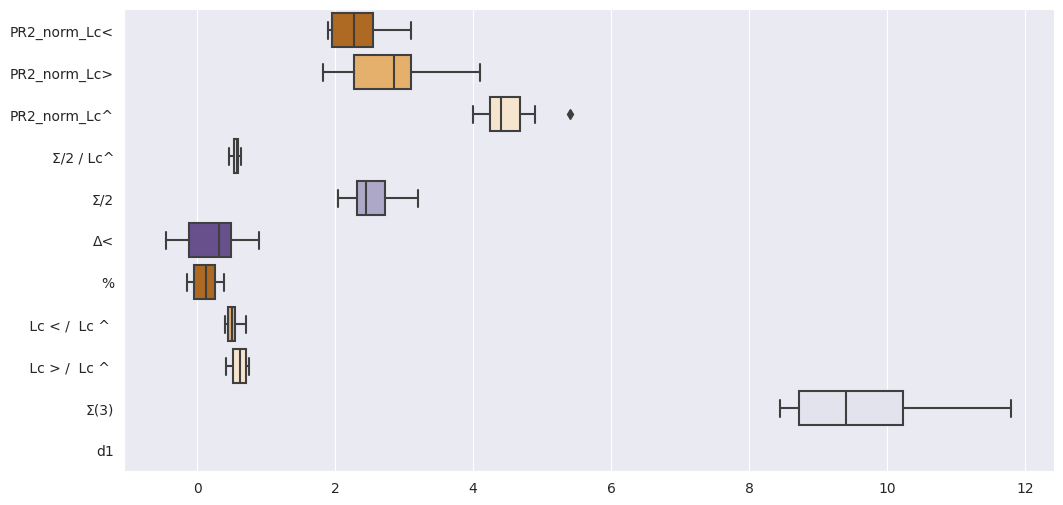

In [ ]:
#задаем маску
mask = df_irsa['d3'] == 'distr'    # diagnosis
distr = df_irsa[mask] # Выбираем данные из датафрейма в соответствии с маской и записываем их в новый даатафрейм temp
print(distr.shape)
plt.figure(figsize=(12,6))
sns.boxplot(data=distr.drop('diagnosis', axis=1), palette=sns.color_palette('PuOr'), orient='h')
plt.show()


In [ ]:
distr

ID  PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^   Σ/2    Δ<  \
14    Nw23          2.60          3.20          4.60   0.630435  2.90  0.30   
15    Nw24          1.90          2.90          4.00   0.600000  2.40  0.50   
53    Nw65          2.26          1.82          4.37   0.466819  2.04 -0.22   
68    Nw85          2.10          2.50          4.00   0.575000  2.30  0.20   
71    Nw89          1.90          2.80          4.70   0.500000  2.35  0.45   
76    Nw96          3.10          2.20          4.40   0.602273  2.65 -0.45   
77    Nw97          1.90          3.10          4.40   0.568182  2.50  0.60   
155  Nw181          2.60          1.90          4.20   0.535714  2.25 -0.35   
182  Nw216          2.40          3.10          4.90   0.561224  2.75  0.35   
193  Nw232          2.30          4.10          5.40   0.592593  3.20  0.90   

            %   Lc < /  Lc ^    Lc > /  Lc ^    Σ(3) diagnosis   d1     d2  \
14   0.115385        0.565217        0.695652  10.40     distr  NaN  distr   
15   0.263158        0.475000        0.725000   8.80     distr  NaN  distr   
53  -0.097345        0.517162        0.416476   8.45     distr  NaN  distr   
68   0.095238        0.525000        0.625000   8.60     distr  NaN  distr   
71   0.236842        0.404255        0.595745   9.40     distr  NaN  distr   
76  -0.145161        0.704545        0.500000   9.70     distr  NaN  distr   
77   0.315789        0.431818        0.704545   9.40     distr  NaN  distr   
155 -0.134615        0.619048        0.452381   8.70     distr  NaN  distr   
182  0.145833        0.489796        0.632653  10.40     distr  NaN  distr   
193  0.391304        0.425926        0.759259  11.80     distr  NaN  distr   

        d3  
14   distr  
15   distr  
53   distr  
68   distr  
71   distr  
76   distr  
77   distr  
155  distr  
182  distr  
193  distr

In [ ]:
distr.describe()

PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^        Σ/2  \
count     10.000000     10.000000      10.00000  10.000000  10.000000   
mean       2.306000      2.762000       4.49700   0.563224   2.534000   
std        0.387476      0.686858       0.42776   0.049969   0.344809   
min        1.900000      1.820000       4.00000   0.466819   2.040000   
25%        1.950000      2.275000       4.24250   0.542092   2.312500   
50%        2.280000      2.850000       4.40000   0.571591   2.450000   
75%        2.550000      3.100000       4.67500   0.598148   2.725000   
max        3.100000      4.100000       5.40000   0.630435   3.200000   

              Δ<          %   Lc < /  Lc ^    Lc > /  Lc ^        Σ(3)  
count  10.000000  10.000000       10.000000       10.000000  10.000000  
mean    0.228000   0.118643        0.515777        0.610671   9.565000  
std     0.438249   0.191412        0.093528        0.118842   1.052523  
min    -0.450000  -0.145161        0.404255        0.416476   8.450000  
25%    -0.115000  -0.049199        0.442614        0.523936   8.725000  
50%     0.325000   0.130609        0.503479        0.628827   9.400000  
75%     0.487500   0.256579        0.555163        0.702322  10.225000  
max     0.900000   0.391304        0.704545        0.759259  11.800000

## MEZIAL

(37, 12)


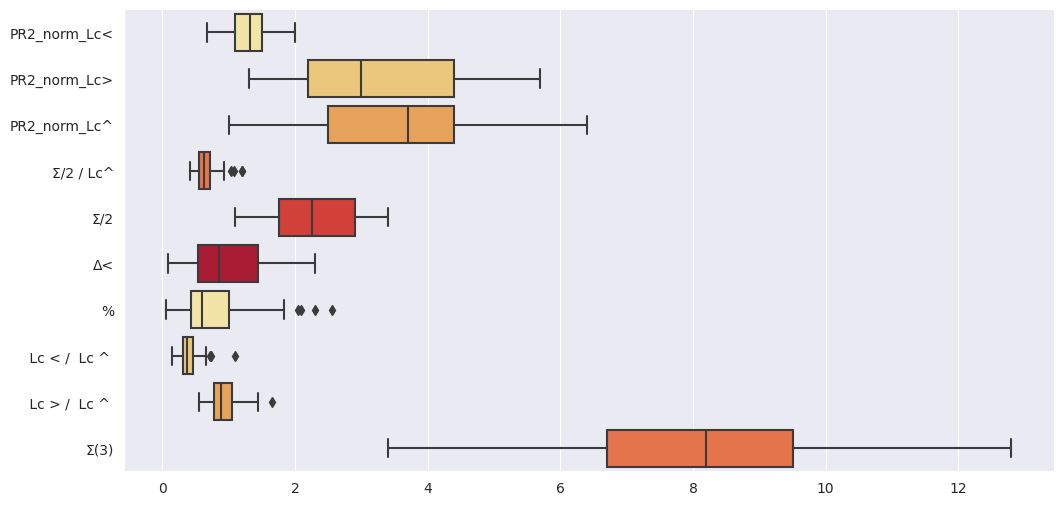

In [ ]:
#задаем маску
mask = df_irsa['diagnosis'] == 'mezial'
mezial = df_irsa[mask] # Выбираем данные из датафрейма в соответствии с маской и записываем их в новый даатафрейм temp
print(mezial.shape)
plt.figure(figsize=(12,6))
sns.boxplot(data=mezial.drop('diagnosis', axis=1), palette=sns.color_palette('YlOrRd'), orient='h')
plt.show()


In [ ]:
#mezial.head(5)
mezial

ID  PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^    Σ/2  \
22     Nw31          1.70          3.80          2.30   1.195652  2.750   
27     Nw36          0.90          5.50          6.40   0.500000  3.200   
29     Nw38          1.30          3.00          3.30   0.651515  2.150   
31     Nw40          0.67          1.74          2.09   0.576555  1.205   
32     Nw41          1.60          2.90          4.00   0.562500  2.250   
37     Nw47          1.40          3.10          4.40   0.511364  2.250   
50     Nw60          1.40          4.20          3.70   0.756757  2.800   
51     Nw61          1.10          3.70          4.40   0.545455  2.400   
52     Nw62          1.40          4.30          4.50   0.633333  2.850   
57     Nw72          1.02          5.19          5.64   0.550532  3.105   
59    Nw74x          1.51          1.68          2.78   0.573741  1.595   
60    Nw75x          1.33          2.19          3.68   0.478261  1.760   
87    Nw107          1.10          2.30          4.00   0.425000  1.700   
94    Nw115          1.10          5.70          5.60   0.607143  3.400   
96    Nw117          1.50          2.80          2.30   0.934783  2.150   
105   Nw127          0.80          1.90          1.90   0.710526  1.350   
106   Nw128          1.00          2.10          2.40   0.645833  1.550   
107   Nw129          2.00          4.40          3.10   1.032258  3.200   
117   Nw139          1.20          2.40          3.10   0.580645  1.800   
125   Nw149          1.00          5.60          4.20   0.785714  3.300   
131   Nw155          1.60          5.20          5.30   0.641509  3.400   
133   Nw157          1.00          1.90          2.00   0.725000  1.450   
146   Nw172          1.70          4.90          5.50   0.600000  3.300   
157   Nw183          1.80          3.60          2.50   1.080000  2.700   
159   Nw185          1.30          4.50          3.60   0.805556  2.900   
161   Nw187          1.10          1.30          1.00   1.200000  1.200   
165   Nw194          0.70          1.50          1.50   0.733333  1.100   
167  Nw197_          1.20          1.70          2.20   0.659091  1.450   
180   Nw214          1.50          4.40          4.20   0.702381  2.950   
181   Nw215          1.20          5.60          4.90   0.693878  3.400   
184   Nw218          1.40          3.00          3.80   0.578947  2.200   
185   Nw220          1.50          2.40          4.30   0.453488  1.950   
186   Nw221          1.60          2.90          4.10   0.548780  2.250   
187   Nw222          1.50          3.30          4.40   0.545455  2.400   
192   Nw230          1.30          3.00          3.70   0.581081  2.150   
196   Nw235          1.80          2.70          3.10   0.725806  2.250   
206   Nw251          1.40          2.20          3.80   0.473684  1.800   

        Δ<         %   Lc < /  Lc ^    Lc > /  Lc ^    Σ(3) diagnosis  
22   1.050  0.617647        0.739130        1.652174   7.80    mezial  
27   2.300  2.555556        0.140625        0.859375  12.80    mezial  
29   0.850  0.653846        0.393939        0.909091   7.60    mezial  
31   0.535  0.798507        0.320574        0.832536   4.50    mezial  
32   0.650  0.406250        0.400000        0.725000   8.50    mezial  
37   0.850  0.607143        0.318182        0.704545   8.90    mezial  
50   1.400  1.000000        0.378378        1.135135   9.30    mezial  
51   1.300  1.181818        0.250000        0.840909   9.20    mezial  
52   1.450  1.035714        0.311111        0.955556  10.20    mezial  
57   2.085  2.044118        0.180851        0.920213  11.85    mezial  
59   0.085  0.056291        0.543165        0.604317   5.97    mezial  
60   0.430  0.323308        0.361413        0.595109   7.20    mezial  
87   0.600  0.545455        0.275000        0.575000   7.40    mezial  
94   2.300  2.090909        0.196429        1.017857  12.40    mezial  
96   0.650  0.433333        0.652174        1.217391   6.60    mezial  
105  0

In [ ]:
#  Nw78 - 2 выброса Σ(3),  PR2_norm_Lc^

In [ ]:
mezial.describe()

PR2_norm_Lc<  PR2_norm_Lc>  PR2_norm_Lc^  Σ/2 / Lc^        Σ/2  \
count     37.000000     37.000000     37.000000  37.000000  37.000000   
mean       1.314324      3.313514      3.613243   0.675826   2.313919   
std        0.313258      1.329217      1.260556   0.192941   0.711532   
min        0.670000      1.300000      1.000000   0.425000   1.100000   
25%        1.100000      2.200000      2.500000   0.550532   1.760000   
50%        1.330000      3.000000      3.700000   0.633333   2.250000   
75%        1.500000      4.400000      4.400000   0.725806   2.900000   
max        2.000000      5.700000      6.400000   1.200000   3.400000   

              Δ<          %   Lc < /  Lc ^    Lc > /  Lc ^        Σ(3)  
count  37.000000  37.000000       37.000000       37.000000  37.000000  
mean    0.999595   0.810061        0.411463        0.940189   8.241081  
std     0.652837   0.619708        0.183765        0.264513   2.510992  
min     0.085000   0.056291        0.140625        0.558140   3.400000  
25%     0.535000   0.433333        0.311111        0.772727   6.700000  
50%     0.850000   0.600000        0.368421        0.890909   8.200000  
75%     1.450000   1.000000        0.466667        1.047619   9.500000  
max     2.300000   2.555556        1.100000        1.652174  12.800000